Full name: Michael Hollins

CID: 02553236

Imperial Username: mdh323

# DGL CW1
Hi everyone, good luck on the first CW of the DGL course. Please do not hesitate to ask your questions on EdStem if you have any.

## Questions
1. Centrality-based Graph Classification (25 points)
2. Implementation of GraphSAGE with Node Sampling (30 points)
3. Attention-based aggregation in node classification (30 points)
4. Propagation rule integrating edge features/embeddings (15 points)
5. Bonus Questions (5 points)

## Submission Instructions
For submission, you only need to submit your Jupyter Notebook file named "CID.ipynb"


# Required Libraries and Imports

In [3]:
%pip install dgl

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Standard library imports
import random
import math
import copy
import time

# Data handling, numerical processing, and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning, neural network modules, and metrics
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Graph processing
import networkx as nx

# DGL and datasets
from dgl.data import PPIDataset, CoraGraphDataset

# Set a fixed random seed for reproducibility across multiple libraries
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Check for CUDA (GPU support) and set device accordingly
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # For multi-GPU setups
    # Additional settings for ensuring reproducibility on CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device("cpu")
    print("CUDA not available. Using CPU.")


CUDA not available. Using CPU.


# 1) Centrality-based Graph Classification (25 points)

## Part 1: Implementing and Analyzing PageRank Centrality

### Objective
The goal of this task is to enhance your comprehension of the PageRank centrality algorithm through hands-on implementation. You are tasked with coding the algorithm from the ground up and applying it to two specific graphs, named $G1$ and $G2$. Following the application, you will analyze and compare the PageRank distributions between these two graphs.

### Total Points: 10

---

### Instructions

#### 1. **Implement the PageRank Algorithm**

- **Initialization**: Assign an equal PageRank to every node initially. For a graph containing $N$ nodes, each node's starting PageRank is $1/N$.

- **Calculation**: Update each node's PageRank by employing the formula:
  $$PR(p_i) = \frac{1-d}{N} + d \sum_{p_j \in M(p_i)} \frac{PR(p_j)}{L(p_j)}$$
  where:
  - $PR(p_i)$ denotes the PageRank of page $p_i$,
  - $d$ represents the damping factor, usually set at 0.85,
  - $N$ is the total count of nodes within the graph,
  - $M(p_i)$ encompasses the set of nodes linking to $p_i$,
  - $L(p_j)$ signifies the number of outbound links from node $p_j$.

- **Convergence**: Continuously recalculate until the PageRank values reach a stable condition, evidenced by negligible changes between successive iterations.

#### 2. **Pre-defined Graphs G1 and G2**

- You have access to two graphs, $G1$ and $G2$, within your environment. These will serve as your experimental subjects for the PageRank algorithm application.

#### 3. **Calculate PageRank Values**

- Implement your PageRank algorithm on both $G1$ and $G2$ to determine the PageRank values for their respective nodes.

#### 4. **Visualize the Results**

- Create plots to showcase the PageRank value distributions for $G1$ and $G2$. Apply a transparent blue overlay for $G1$ and a transparent red for $G2$, facilitating an effortless comparison.

#### 5. **Analysis**

- **Reflect** upon the PageRank distribution variances between $G1$ and $G2$, pondering over:
  - The impact of $G1$ and $G2$ structures on their PageRank distributions.
  - Whether the PageRank values are more clustered or dispersed in one graph relative to the other.
  - The presence of any nodes that emerge as notably more central within their graphs.

### Comment Section

- **Discuss** the insights and observations derived from juxtaposing the PageRank distributions of $G1$ and $G2$. Highlight any discerned patterns or anomalies, and deliberate on how each graph's inherent structure could elucidate these findings.

---


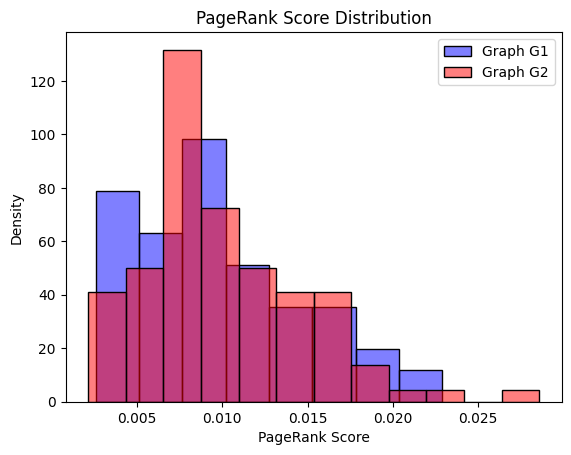

In [3]:
import time

def initialize_page_rank(graph):
    """
    Initialize the PageRank scores for all nodes in a graph.
    - Assume each node has an equal initial PageRank value.
    - The function takes a graph as input and returns a dictionary with nodes as keys and initial PageRank scores as values.
    """
    return {n: 1/len(graph) for n in graph.keys()}

def calculate_page_rank(graph, d=0.85, max_iterations=100, tol=1e-6):
    """
    Calculate the PageRank scores for all nodes in the graph using the iterative PageRank formula.
    
    - Use the iterative PageRank algorithm with the damping factor `d`.
    - Continue iterating until the change in PageRank scores is below `tol` or until `max_iterations` is reached.
    - The function returns a dictionary with nodes as keys and their PageRank scores as values.
    """
    # Initialise objects for the iterative updates
    N = len(graph.keys()) # Total count of nodes within the graph
    teleportation = (1-d)/N # Prevents accumulation of PageRank in sink nodes
    PR = initialize_page_rank(graph)    
    iteration = 0
    PR_diff = 100
    
    while iteration < max_iterations and PR_diff > tol:
        PR_update = {n: teleportation for n in graph.keys()}  # Initialize with teleportation factor
        sink_PR = sum(PR[n] for n in PR if len(graph[n]) == 0)  # Total PageRank of sink nodes
        for n in graph:
            for m in graph[n]:
                PR_update[m] += d * PR[n] / len(graph[n])  # Update PR for each node m connected to n
        for n in graph:
            PR_update[n] += sink_PR * d / N  # Redistribute PageRank of sink nodes
        PR_diff = max(abs(PR[n] - PR_update[n]) for n in PR)  # Calculate max change in PR
        PR = PR_update
        iteration += 1
    return PR

def visualize_distributions(page_ranks_g1, page_ranks_g2):
    """
    Visualizes the distributions of PageRank values for two graphs on the same histogram for comparison.
    
    - Use a histogram to compare the PageRank distributions of two different graphs.
    - Customize the plot with labels, titles, and a legend.
    """
    sns.histplot(page_ranks_g1, color='b', alpha=0.5, label='Graph G1', stat='density')
    sns.histplot(page_ranks_g2, color='r', alpha=0.5, label='Graph G2', stat='density')
    plt.xlabel('PageRank Score')
    plt.ylabel('Density')
    plt.title('PageRank Score Distribution')
    plt.legend()
    plt.show()

# Generating larger graphs G1 and G2 with more complexity
G1 = nx.fast_gnp_random_graph(100, 0.05, directed=True, seed = 1)
G2 = nx.fast_gnp_random_graph(100, 0.05, directed=True, seed = 2)

# Convert NetworkX graphs to adjacency lists
graph_g1 = {n: list(G1.successors(n)) for n in G1.nodes()}
graph_g2 = {n: list(G2.successors(n)) for n in G2.nodes()}

page_rank_g1 = calculate_page_rank(graph_g1)
page_rank_g2 = calculate_page_rank(graph_g2)

visualize_distributions(page_ranks_g1=page_rank_g1, page_ranks_g2=page_rank_g2)

# Further EDA
#sns.histplot({n: len(graph_g1[n]) for n in graph_g1}, color='b', alpha=0.5, label='Graph G1', stat='density')
#sns.histplot({n: len(graph_g2[n]) for n in graph_g2}, color='r', alpha=0.5, label='Graph G2', stat='density')

# sorted_pagerank_g2 = {k: v for k, v in sorted(page_rank_g2.items(), key=lambda item: item[1], reverse=True)}
# print(sorted_pagerank_g2)
# print(graph_g2[77])


## Discussion

Immediately we can see that $G2$ has a relatively large number of nodes with a middling page rank (around 0.0075) and a less even distribution than $G1$. To me, this implies that $G2$ has lower connectivity than $G1$ as $G2$ is less densely connected and so its distribution of pagerank scores is less uniform. In addition, $G2$ appears to have some nodes with relatively large pagerank scores, i.e. it contains some nodes of more importance to the graph. In this particular case, it is node 77 with a pagerank score of 0.028 which implies it is acting as a "hub" for the network. By contrast, $G1$ has more nodes of relatively low importance reflected in lower pagerank scores.

However, at a higher level, the distributions are to a large extent similar because they are generated from the same data-generating distribution (just with different seeds). Were we to change the argument $p$ in nx.fast_gnp_random_graph to get a different probability of edge creation, we would get two more distinct page rank distributions.


## Part 2: Graph Convolutional Networks (GCN) for Graph Classification

### Objective

Your main objective is to modify the degree-based propagation rule using the following topological measures for normalization:
1. **PageRank Centrality**: Utilize the PageRank centrality implementation from Part 1.
2. **Betweenness Centrality**: Implement normalization using Betweenness centrality, which can be calculated using NetworkX.
3. **Clustering Coefficient**: Implement normalization using the Clustering coefficient, available through NetworkX.

For each normalization technique, you will develop a separate GCN model, resulting in four different GNN models including the original degree-based model.

### Total Points: 15

---

### Instructions

#### 1. **Implement a 2-Layer GCN**
- **Graph Representation**: Begin with the simple node degree normalization for your initial GCN implementation. Specifically, employ the normalization technique $D^{-1}A$ where $D$ is the degree matrix and $A$ is the adjacency matrix of the graph.
- **GCN Propagation Rule**: Implement the GCN layer using the updated propagation rule:
  $$H^{(l+1)} = \sigma(D^{-1}AH^{(l)}W^{(l)})$$
  Here, $H^{(l)}$ represents the node features at layer $l$, $W^{(l)}$ is the weight matrix at layer $l$, and $\sigma$ denotes a non-linear activation function, such as ReLU.
- **Architecture**: Design your GCN with two convolutional layers following this propagation rule. Conclude with a Mean Pooling layer to aggregate node embeddings for graph-level prediction.
- **Prediction Head**: Develop a prediction head that processes the pooled graph representation to classify the graph.

#### 2. **Topological Measures for Normalization**
Adapt the degree-based propagation rule to incorporate the following topological measures:
- **PageRank Centrality**: Leverage the PageRank centrality implementation from Part 1.
- **Betweenness Centrality and Clustering Coefficient**: Use NetworkX to compute these centrality measures for each node, applying them as normalization factors in the GCN propagation rule.

#### 3. **Data Preparation**
- Ensure the train and test sets are fixed to guarantee consistent evaluation across the different normalization techniques.

#### 4. **Model Training and Evaluation**
- Independently train a GCN model for each normalization technique.
- Assess the performance of each model, focusing on accuracy, sensitivity, and specificity.

#### 5. **Analysis of Embedding Distributions and Classification Results**
- **Embedding Distributions**: Employ PCA to reduce the dimensionality of embeddings obtained from the final layer (Layer 2) of each GCN model, and visualize these distributions.
- **Classification Results**: Contrast the accuracy, sensitivity, and specificity results among the four models.

### Comment Section

Engage in discussion on the following topics based on your analysis:
- **Comparative Analysis**: Examine how the embedding distributions and classification outcomes differ with each normalization technique.
- **Interpretation of Results**: Reflect on the performances of GCN models under different topological normalizations. Consider how PageRank centrality, betweenness centrality, and clustering coefficient influence the embeddings and classification capabilities of the models.

Delve into the reasons behind the performances observed and theorize how the distinct topological characteristics of graphs may affect GCN model efficacy. Ponder the impact of each normalization method on feature propagation within the network and its capacity to harness the structural information of the graph for classification purposes.


## 1.1 Dataset 

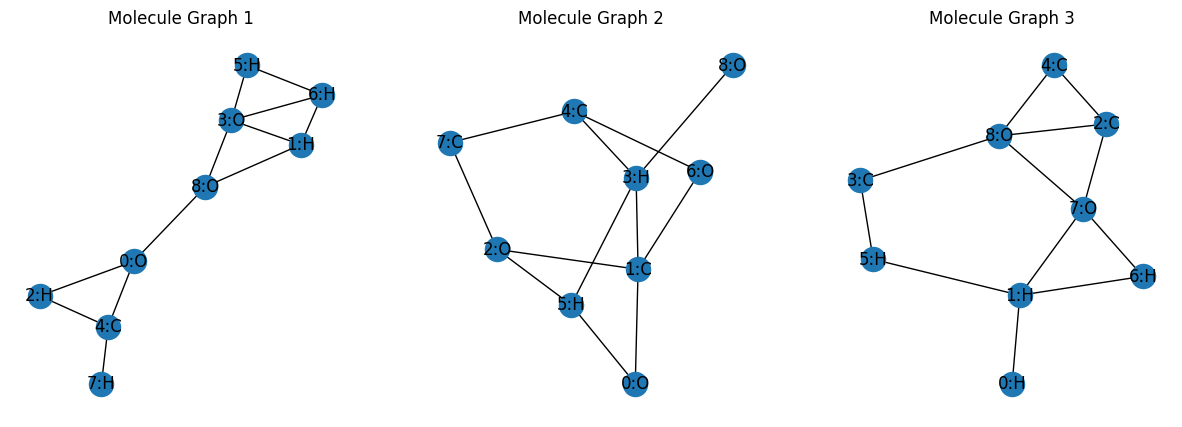

In [4]:
def create_random_molecule_graph(num_atoms=9, num_bonds=12):
    """
    Creates a random molecular graph with a specified number of atoms and bonds.

    Args:
        num_atoms (int): The number of atoms in the molecule.
        num_bonds (int): The number of bonds between atoms in the molecule.

    Returns:
        (nx.Graph, list): A tuple containing the generated molecular graph and the list of atom labels.
    """
    G = nx.Graph()
    atom_labels = [f"{i}:{random.choice(['H', 'C', 'O'])}" for i in range(num_atoms)]
    G.add_nodes_from(atom_labels)

    for _ in range(num_bonds):
        atom1, atom2 = random.choice(atom_labels), random.choice(atom_labels)
        while atom1 == atom2 or G.has_edge(atom1, atom2):
            atom1, atom2 = random.choice(atom_labels), random.choice(atom_labels)
        G.add_edge(atom1, atom2)

    return G, atom_labels

def classify_molecule(G):
    """
    Classifies a molecule into type 1 or type 2 based on more complex criteria (without considering nitrogen).

    Args:
        G (nx.Graph): The molecular graph.

    Returns:
        int: The type of molecule (0 or 1).
    """
    atom_labels = list(G.nodes)
    num_carbon = sum(1 for label in atom_labels if label.endswith(":C"))
    num_oxygen = sum(1 for label in atom_labels if label.endswith(":O"))
    num_hydrogen = sum(1 for label in atom_labels if label.endswith(":H"))
    num_bonds = len(G.edges)

    # Define more complex criteria for classification
    if num_oxygen >= 2 and num_hydrogen >= 3 and num_carbon >= 2 and num_bonds >= 4:
        return 1
    elif num_oxygen >= 1 and num_carbon >= 3 and num_hydrogen >= 2 and num_bonds >= 3:
        return 0
    else:
        return 2


def generate_balanced_molecule_dataset(num_samples_per_type):
    """
    Generates a balanced dataset of random molecule graphs.

    Args:
        num_samples_per_type (int): The number of samples per molecule type.

    Returns:
        list: A list of tuples, each containing a graph, its atom labels, and its classification.
    """
    dataset = []
    while len(dataset) < num_samples_per_type * 2:
        G, atom_labels = create_random_molecule_graph()
        classification = classify_molecule(G)
        if classification in [0, 1]:
            dataset.append((G, atom_labels, classification))
    return dataset


def graph_to_tensors(G, atom_labels, normalization_func=None):
    """
    Converts a networkx graph of a molecule into tensor representations, with optional adjacency matrix normalization.

    Args:
        G (nx.Graph): The molecular graph.
        atom_labels (list): List of atom labels in the molecule.
        normalization_func (callable, optional): Function to normalize the adjacency matrix.

    Returns:
        tuple: A tuple containing the tensor representation of atom types (X) and (optionally normalized) adjacency matrix (A).
    """
    atom_types = {'H': [1, 0, 0], 'C': [0, 1, 0], 'O': [0, 0, 1]}
    X = torch.tensor([atom_types[node.split(':')[1]] for node in atom_labels], dtype=torch.float)

    N = len(atom_labels)
    A = torch.zeros((N, N), dtype=torch.float)
    for i, j in G.edges:
        idx1 = atom_labels.index(i)
        idx2 = atom_labels.index(j)
        A[idx1, idx2] = 1
        A[idx2, idx1] = 1

    if normalization_func:
        A = normalization_func(G, A)  # Apply normalization if provided

    return X, A

from torch.utils.data import Dataset
import torch

class MoleculeDataset(Dataset):
    """
    A custom dataset class for handling molecular graphs. Each sample in the dataset represents a molecule,
    characterized by its graph structure and atom features, along with a classification label (e.g., for binary classification tasks).

    The dataset initializes with a list of molecular data and optionally applies a normalization function to the adjacency matrix
    of each molecule's graph. This normalization can be crucial for certain graph neural network models, affecting how the model
    interprets the connectivity and flow of information through the graph.

    Attributes:
        dataset (list): A list of tuples, where each tuple corresponds to a molecule and contains:
                        - A graph representation of the molecule (e.g., a `networkx` graph).
                        - Atom labels or features as a list or array.
                        - A classification label for the molecule.
        normalization_func (callable, optional): A function that takes an adjacency matrix (and potentially a graph) as input
                        and returns a normalized adjacency matrix. This can be any normalization technique, such as degree normalization,
                        PageRank-based normalization, etc.

    The class provides two main methods as part of the PyTorch `Dataset` interface:
    - `__len__` returns the number of items in the dataset.
    - `__getitem__` retrieves a single item from the dataset by index, applying the normalization function if provided.

    #TODO: Implement the `__init__` method to initialize the dataset with the given list and normalization function.
    - Store the provided dataset list and normalization function as instance attributes.

    #TODO: Implement the `__len__` method to return the size of the dataset.
    - This method should simply return the length of the dataset list.

    #TODO: Implement the `__getitem__` method to fetch and preprocess a single graph representation from the dataset.
    - Extract the graph `G`, atom labels `atom_labels`, and classification `classification` for the specified index `idx`.
    - Convert the graph `G` and `atom_labels` into tensor formats suitable for graph neural networks. This often involves creating a feature matrix `X` for nodes and an adjacency matrix `A`. Use the `graph_to_tensors` function (to be implemented separately by the student) for this conversion. Apply the `normalization_func` to the adjacency matrix if provided.
    - Convert the `classification` label into a tensor of type `torch.long`.
    - Return the feature matrix `X`, the (optionally normalized) adjacency matrix `A`, and the label tensor.
    """
    def __init__(self, dataset, normalization_func=None):
        # Initialize the dataset and the normalization function.
        self.dataset = dataset
        self.normalization_func = normalization_func

    def __len__(self):
        # Return the number of items in the dataset.
        return len(self.dataset)

    def __getitem__(self, idx):
        # Process and return a single item from the dataset as tensors.
        G = self.dataset[idx][0]
        atom_labels = self.dataset[idx][1]
        classification = classify_molecule(G)
        X, A = graph_to_tensors(G, atom_labels, normalization_func=self.normalization_func)
        label_tensor = torch.tensor(classification, dtype=torch.long)
        return X, A, label_tensor
        

def prepare_data_loaders(num_samples_per_type, normalization_func=None, batch_size=10):
    """
    Prepares DataLoader for training and testing datasets.

    Args:
        num_samples_per_type (int): Number of samples per class to generate.
        normalization_func (callable, optional): Normalization function to apply to adjacency matrices.
        batch_size (int): Size of each data batch.

    Returns:
        Tuple of DataLoader: Training and testing DataLoader objects.
    """
    dataset = generate_balanced_molecule_dataset(num_samples_per_type)
    train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=random_seed)

    train_dataset = MoleculeDataset(train_dataset, normalization_func=normalization_func)
    test_dataset = MoleculeDataset(test_dataset, normalization_func=normalization_func)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# Your GCNLayer and GCN classes remain unchanged.

# Generating a few random molecule graphs for visualization
graphs = [create_random_molecule_graph() for _ in range(3)]

# Plotting the generated graphs
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (G, atom_labels) in enumerate(graphs):
    pos = nx.spring_layout(G)  # Using spring layout for visual aesthetics
    nx.draw(G, pos, with_labels=True, ax=axes[i])
    axes[i].set_title(f"Molecule Graph {i+1}")

plt.show()

## 1.2 Visualization Helper Functions

In [5]:
def visualize_omega_distribution(layers, epochs):
    """
    Visualizes the distribution of weights (Omega) in each GCN layer of the Graph Neural Network across different epochs using smooth KDE plots.

    Args:
        layers (list of tuples): Each tuple contains a layer's name and a list of arrays representing the layer's weights at different epochs.
        epochs (list of int): List of epoch numbers corresponding to the weight arrays.

    This function plots the kernel density estimation (KDE) of weight values for each layer across specified epochs, allowing for the observation of how weight distributions evolve during training.
    """
    for layer_name, weight_arrays in layers:
        plt.figure(figsize=(12, 6))
        for i, weights in enumerate(weight_arrays):
            omega_values = weights.flatten()  # Flatten the array to get a distribution of individual weight values
            sns.kdeplot(omega_values, fill=True, label=f'Epoch {epochs[i]}')  # Use 'fill' for shaded KDE plots
        plt.title(f'{layer_name} Weight Distribution Across Epochs', fontsize=16)
        plt.xlabel('Weight Values', fontsize=12)
        plt.ylabel('Density', fontsize=12)
        plt.legend()
        plt.show()


def plot_training_losses(losses_list, normalization_names):
    """
    Plots the training loss over epochs for different normalization techniques.

    Args:
        losses_list (list of lists): Each sublist contains the training losses for one normalization technique over all epochs.
        normalization_names (list of str): Names of the normalization techniques used.

    This function creates a line plot for each normalization technique's training loss over epochs, facilitating comparison of their performance.
    """
    plt.figure(figsize=(10, 6))
    for i, train_losses in enumerate(losses_list):
        plt.plot(range(1, len(train_losses) + 1), train_losses, label=f'{normalization_names[i]} Normalization')
    plt.title('Training Loss Over Epochs for Different Normalization Techniques', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_metric_bar_charts(names, metric_values, metric_names):
    """
    Creates bar charts for different evaluation metrics across various normalization techniques.

    Args:
        names (list of str): Names of the normalization techniques.
        metric_values (list of lists): Each sublist contains the values of a metric for each normalization technique.
        metric_names (list of str): Names of the metrics being plotted.

    This function plots a bar chart for each provided metric, comparing the performance of different normalization techniques,
    with y-axis limits dynamically adjusted to emphasize differences while capping at 1.
    """
    num_metrics = len(metric_names)
    num_rows = num_cols = int(math.ceil(math.sqrt(num_metrics)))

    sns.set(style='whitegrid', palette='muted', font_scale=1.2)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12 * num_cols, 8 * num_rows))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for i, metric_name in enumerate(metric_names):
        ax = axes.flatten()[i] if num_metrics > 1 else axes

        # Create DataFrame for seaborn
        data = pd.DataFrame({
            'Normalization Technique': np.repeat(names, len(metric_values[i])),
            metric_name: np.concatenate([metric_values[i] for _ in names])
        })

        sns.barplot(x='Normalization Technique', y=metric_name, data=data, ax=ax, alpha=0.75)

        # Dynamically adjust the y-axis limits
        min_val = min(data[metric_name]) * 0.9  # Start slightly below the smallest value for better visibility
        max_val = 1  # Ensuring the upper limit is 1
        ax.set_ylim([min_val, max_val])

        ax.set_xlabel('Normalization Technique', fontsize=14)
        ax.set_ylabel(f'{metric_name} Value', fontsize=14)
        ax.set_title(f'Comparison of {metric_name}', fontsize=16)
        ax.tick_params(axis='x', rotation=45, labelsize=12)
        ax.tick_params(axis='y', labelsize=12)

        # Add text labels above bars
        for p, value in zip(ax.patches, np.concatenate([metric_values[i] for _ in names])):
            ax.text(p.get_x() + p.get_width() / 2., p.get_height(), f'{value:.2f}', ha='center', va='bottom', fontsize=10)

    # Hide unused subplots if the number of metrics is less than the number of subplot positions
    for i in range(num_metrics, num_rows * num_cols):
        if num_rows * num_cols == 1:
            break
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.show()


def extract_embeddings(model, loader, device='cpu'):
    """
    Extracts embeddings from a model given a data loader.

    #TODO: Implement this function to extract embeddings from the provided model using data from the loader.
    - Set the model to evaluation mode.
    - Initialize lists or arrays to store embeddings and labels.
    - Iterate over batches of data from the loader, ensuring to move the data to the specified device.
    - For each batch, use the model to compute embeddings. If the model requires specific inputs (e.g., features and adjacency matrix), ensure they are correctly passed.
    - Apply necessary post-processing on embeddings (e.g., mean pooling) and convert them to a suitable format (e.g., numpy array) for further analysis or visualization.
    - Collect and store the labels associated with each embedding for potential use in tasks like visualization or analysis.
    - Return the embeddings and labels as a tuple. Ensure embeddings are in a continuous array format suitable for analysis.
    
    Args:
        model (torch.nn.Module): The trained model from which to extract embeddings.
        loader (DataLoader): DataLoader providing batches of data for embedding extraction.
        device (str): Device to run the model on ('cpu' or 'cuda').

    Returns:
        tuple: A tuple containing two elements. The first is a numpy array of embeddings, and the second is a list of labels associated with each embedding.

    Note: This function should handle device placement (CPU or GPU) for both the data and model, and ensure gradients are not computed to optimize memory and compute resources.
    """
    model.eval() # Set the model to evaluation mode
    embeddings_list = []
    label_list = []
    
    # Iterate over the data batches
    for X, A, labels in loader:
            # Move data to the specified device
            X, A, labels = X.to(device), A.to(device), labels.to(device)
            #Use the model to compute embeddings
            with torch.no_grad():  # Ensure no gradients are computed
                embeddings = model(X, A, return_embedding=True)
            embeddings_list.append(embeddings.numpy())
            label_list.append(labels) 
    label_list = torch.cat(label_list).tolist()
    return (embeddings_list, label_list)
    
            
def apply_pca_and_visualize_all_sns(embeddings_list, titles, labels_list):
    """
    Applies PCA to reduce dimensionality of embeddings and visualizes them using scatter plots.

    Args:
        embeddings_list (list of np.ndarray): List of embeddings arrays to be visualized.
        titles (list of str): Titles for each subplot, typically representing the condition or category of the embeddings.
        labels_list (list of np.ndarray): List of label arrays corresponding to the embeddings for coloring the points.

    This function reduces embeddings to two principal components using PCA and plots them, coloring points by their labels to distinguish between categories.
    """
    sns.set(style='whitegrid')
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    axs = axs.flatten()

    for i, (embeddings, title, labels) in enumerate(zip(embeddings_list, titles, labels_list)):
        embeddings = np.array(embeddings)
        if embeddings.ndim > 2:
            embeddings = embeddings.reshape(-1, embeddings.shape[-1])
        pca = PCA(n_components=2)
        pca_embeddings = pca.fit_transform(embeddings)
        df = pd.DataFrame(data=pca_embeddings, columns=['PCA1', 'PCA2'])
        df['Label'] = labels # Add labels for coloring
        sns.scatterplot(ax=axs[i], x='PCA1', y='PCA2', hue='Label', data=df, palette='viridis', alpha=0.7).set_title(title)
        axs[i].set_xlabel('PCA Component 1')
        axs[i].set_ylabel('PCA Component 2')

    plt.tight_layout()
    plt.show()

## 1.3 Model 

In [6]:
class GCNLayer(nn.Module):
    """
    Implements a single Graph Convolutional Layer.

    #TODO: Implement a GCN layer that performs graph convolution. This layer should first apply a linear transformation
    to the node features and then utilize the adjacency matrix to incorporate neighborhood information. You will need to
    define and initialize a weight matrix for the linear transformation of node features.
    
    Attributes:
        - Define an attribute for the weight matrix.

    Args:
        - Accept the number of input features per node.
        - Accept the number of output features per node.
    """
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        #TODO: Initialize the weight matrix as a torch.nn.Parameter.
        self.in_features = in_features
        self.out_features = out_features
        self.init_parameters()

    def init_parameters(self):
        #TODO: Implement a method to initialize the weights uniformly with a standard deviation based on layer size.
        # I will assume this means using Xavier-Glorot initialisation
        self.weight = torch.nn.Parameter(torch.empty(self.in_features, self.out_features, dtype=torch.float32))
        torch.nn.init.xavier_uniform_(self.weight)

    def forward(self, input, adjacency):
        """
        Forward pass of the GCN layer.
        
        #TODO: Implement the forward pass method. Apply a linear transformation to the input features and then
        use the adjacency matrix to incorporate neighborhood information. The method should return the output feature
        matrix after graph convolution.
        
        Args:
            - input: Input feature matrix where each row represents node features.
            - adjacency: Adjacency matrix of the graph.
        
        Returns:
            - Output feature matrix after applying the graph convolution.
        """
        agg = torch.matmul(adjacency, input)
        agg = agg.to(dtype=torch.float32)
        H_k_next = torch.matmul(agg, self.weight)
        return H_k_next

class GCN(nn.Module):
    """
    Implements a Graph Convolutional Network (GCN) for node classification.

    #TODO: Implement a GCN model for node classification. The model should consist of two GCN layers followed by a
    global mean pooling and a fully connected layer for classification. You need to define the GCN layers and the fully
    connected layer in the constructor.
    
    Args:
        - nfeat: Number of features for each input node.
        - nhid: Number of hidden units for each GCN layer.
        - nclass: Number of classes (output dimension).
    """
    def __init__(self, nfeat, nhid, nclass):
        super(GCN, self).__init__()
        #TODO: Define the first and second graph convolutional layers and the fully connected layer for classification.
        self.gcn1 = GCNLayer(nfeat, nhid)
        self.gcn2 = GCNLayer(nhid, nhid)
        self.fc = nn.Linear(nhid, nclass)

    def forward(self, x, adj, return_embedding=False):
        """
        Forward pass of the GCN.
        
        #TODO: Implement the forward pass. Apply two GCN layers with ReLU activation, perform global mean pooling,
        and then use a fully connected layer for classification. If `return_embedding` is True, return the embedding
        from the second GCN layer before classification.
        
        Args:
            - x: Input feature matrix where each row is the feature vector of a node.
            - adj: Adjacency matrix of the graph.
            - return_embedding: If True, returns the embedding from the second GCN layer before classification.
        
        Returns:
            - The raw output logits for node classification if return_embedding is False, otherwise
            returns the embeddings from the second GCN layer.
        """
        H1 = F.relu(self.gcn1(x, adj))
        H2 = F.relu(self.gcn2(H1, adj))
        global_mean_pooling = torch.mean(H2, dim=1)

        if return_embedding:
            return global_mean_pooling
        else:
            output = self.fc(global_mean_pooling)
            return output

## 1.4 Normalization Methods

In [7]:
def compute_degree_matrix_normalization(G, adjacency):
    """
    Computes the degree matrix normalization D^-1 * A for the given graph.

    #TODO: Implement this function to normalize the adjacency matrix by the inverse degree of each node.
    - Calculate the degree for each node.
    - Compute the inverse degree matrix D^-1.
    - Normalize the adjacency matrix using D^-1 * A.
    - Ensure to handle cases with isolated nodes by adding a small epsilon to the degrees to prevent division by zero.
    - Convert and return the normalized adjacency matrix as a PyTorch tensor.
    """
    epsilon = 1e-5
    degrees = [val + epsilon for (node, val) in G.degree()]
    D_inv = torch.tensor(np.diag(1 / np.array(degrees)), dtype=torch.float32)
    A_norm = torch.matmul(D_inv, adjacency)
    return A_norm

def compute_pagerank_normalization(G, adjacency):
    """
    Normalizes the adjacency matrix using PageRank centrality values.

    #TODO: Implement this function to apply PageRank normalization on the adjacency matrix.
    - Compute PageRank values for each node in the graph.
    - Create a diagonal matrix with PageRank values.
    - Normalize the adjacency matrix using the PageRank diagonal matrix.
    - Convert and return the normalized adjacency matrix as a PyTorch tensor.
    """
    D = torch.tensor(list(nx.pagerank(G).values()), dtype = torch.float32)
    D = torch.diag(D)
    A_norm = torch.matmul(D, adjacency)
    return A_norm

def compute_betweenness_normalization(G, adjacency):
    """
    Normalizes the adjacency matrix using Betweenness centrality values.

    #TODO: Implement this function to utilize Betweenness centrality for adjacency matrix normalization.
    - Calculate Betweenness centrality for each node.
    - Construct a diagonal matrix using the centrality values.
    - Apply this matrix to normalize the adjacency matrix.
    - Convert and return the normalized adjacency matrix as a PyTorch tensor.
    """
    D = torch.tensor(list(nx.betweenness_centrality(G).values()), dtype = torch.float32)
    D = torch.diag(D)
    A_norm = torch.matmul(D, adjacency)
    return A_norm

def compute_clustering_coefficient_normalization(G, adjacency):
    """
    Normalizes the adjacency matrix using Clustering coefficient values.

    #TODO: Implement this function to leverage Clustering coefficients for adjacency matrix normalization.
    - Compute the Clustering coefficient for each node.
    - Form a diagonal matrix with these coefficients.
    - Normalize the adjacency matrix using this coefficient matrix.
    - Convert and return the normalized adjacency matrix as a PyTorch tensor.
    """
    D = torch.tensor(list(nx.clustering(G).values()), dtype = torch.float32)
    D = torch.diag(D)
    A_norm = torch.matmul(D, adjacency)
    return A_norm

## 1.5 Training & Evaluation 

In [8]:
def train_model(model, train_loader, optimizer, criterion, epochs=100, device='cpu'):
    """
    Trains the model over a specified number of epochs.

    Args:
        model (torch.nn.Module): The neural network model to be trained.
        train_loader (torch.utils.data.DataLoader): DataLoader for the training data.
        optimizer (torch.optim.Optimizer): Optimizer used for model parameter updates.
        criterion (torch.nn.Module): Loss function used for training.
        epochs (int, optional): Number of epochs to train the model. Defaults to 100.
        device (str, optional): The device to run the model on ('cpu' or 'cuda'). Defaults to 'cpu'.

    Returns:
        list: A list containing the average loss value for each epoch.

    This function iterates over the training dataset for a given number of epochs, performing
    forward and backward passes, and updates the model parameters. The average loss per epoch is recorded and returned.
    """
    model.train()  # Set the model to training mode
    loss_values = []  # Initialize a list to store the average loss per epoch

    for epoch in range(epochs):
        total_loss = 0  # Track total loss for each epoch

        for X, A, labels in train_loader:
            # Move data to the specified device
            X, A, labels = X.to(device), A.to(device), labels.to(device)
            optimizer.zero_grad()  # Clear gradients for the next train step
            output = model(X, A)  # Forward pass

            loss = criterion(output, labels)  # Compute the loss
            loss.backward()  # Backward pass to compute gradients
            optimizer.step()  # Update model parameters

            total_loss += loss.item()  # Accumulate the loss

        avg_loss = total_loss / len(train_loader)  # Calculate average loss
        loss_values.append(avg_loss)  # Append average loss to list

        # Print the average loss for the current epoch
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

    return loss_values


def evaluate_model(model, test_loader, device='cpu'):
    """
    Evaluates the model on a test dataset.

    Args:
        model (torch.nn.Module): The neural network model to be evaluated.
        test_loader (torch.utils.data.DataLoader): DataLoader for the test data.
        device (str, optional): The device to run the model on ('cpu' or 'cuda'). Defaults to 'cpu'.

    Returns:
        tuple: A tuple containing the accuracy, precision, recall, and F1 score of the model on the test dataset.

    This function performs a forward pass on the test dataset to obtain the model's predictions,
    then calculates and returns various evaluation metrics including accuracy, precision, recall, and F1 score.
    """
    model.eval()  # Set the model to evaluation mode
    true_labels = []  # List to store actual labels
    predictions = []  # List to store model predictions

    with torch.no_grad():  # Disable gradient computation
        for X, A, labels in test_loader:
            # Move data to the specified device
            X, A, labels = X.to(device), A.to(device), labels.to(device)

            output = model(X, A)  # Forward pass
            _, predicted = torch.max(output.data, 1)  # Get the index of the max log-probability

            true_labels += labels.tolist()  # Append actual labels
            predictions += predicted.tolist()  # Append predicted labels

    # Calculate evaluation metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')

    return accuracy, precision, recall, f1



## 1.6 Main Script


Training model with degree normalization...
DataLoader batch size: 50
Epoch 1/200, Loss: 0.6684
Epoch 2/200, Loss: 0.6583
Epoch 3/200, Loss: 0.6472
Epoch 4/200, Loss: 0.6348
Epoch 5/200, Loss: 0.6202
Epoch 6/200, Loss: 0.6040
Epoch 7/200, Loss: 0.5853
Epoch 8/200, Loss: 0.5675
Epoch 9/200, Loss: 0.5492
Epoch 10/200, Loss: 0.5353
Epoch 11/200, Loss: 0.5237
Epoch 12/200, Loss: 0.5153
Epoch 13/200, Loss: 0.5084
Epoch 14/200, Loss: 0.5038
Epoch 15/200, Loss: 0.5002
Epoch 16/200, Loss: 0.4982
Epoch 17/200, Loss: 0.4960
Epoch 18/200, Loss: 0.4945
Epoch 19/200, Loss: 0.4939
Epoch 20/200, Loss: 0.4934
Epoch 21/200, Loss: 0.4924
Epoch 22/200, Loss: 0.4913
Epoch 23/200, Loss: 0.4908
Epoch 24/200, Loss: 0.4908
Epoch 25/200, Loss: 0.4898
Epoch 26/200, Loss: 0.4893
Epoch 27/200, Loss: 0.4903
Epoch 28/200, Loss: 0.4883
Epoch 29/200, Loss: 0.4881
Epoch 30/200, Loss: 0.4886
Epoch 31/200, Loss: 0.4879
Epoch 32/200, Loss: 0.4873
Epoch 33/200, Loss: 0.4867
Epoch 34/200, Loss: 0.4864
Epoch 35/200, Loss: 

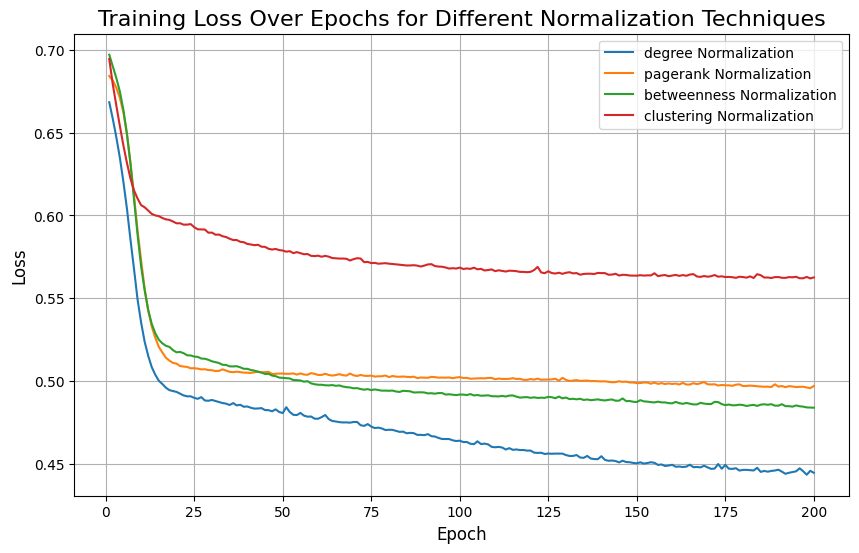

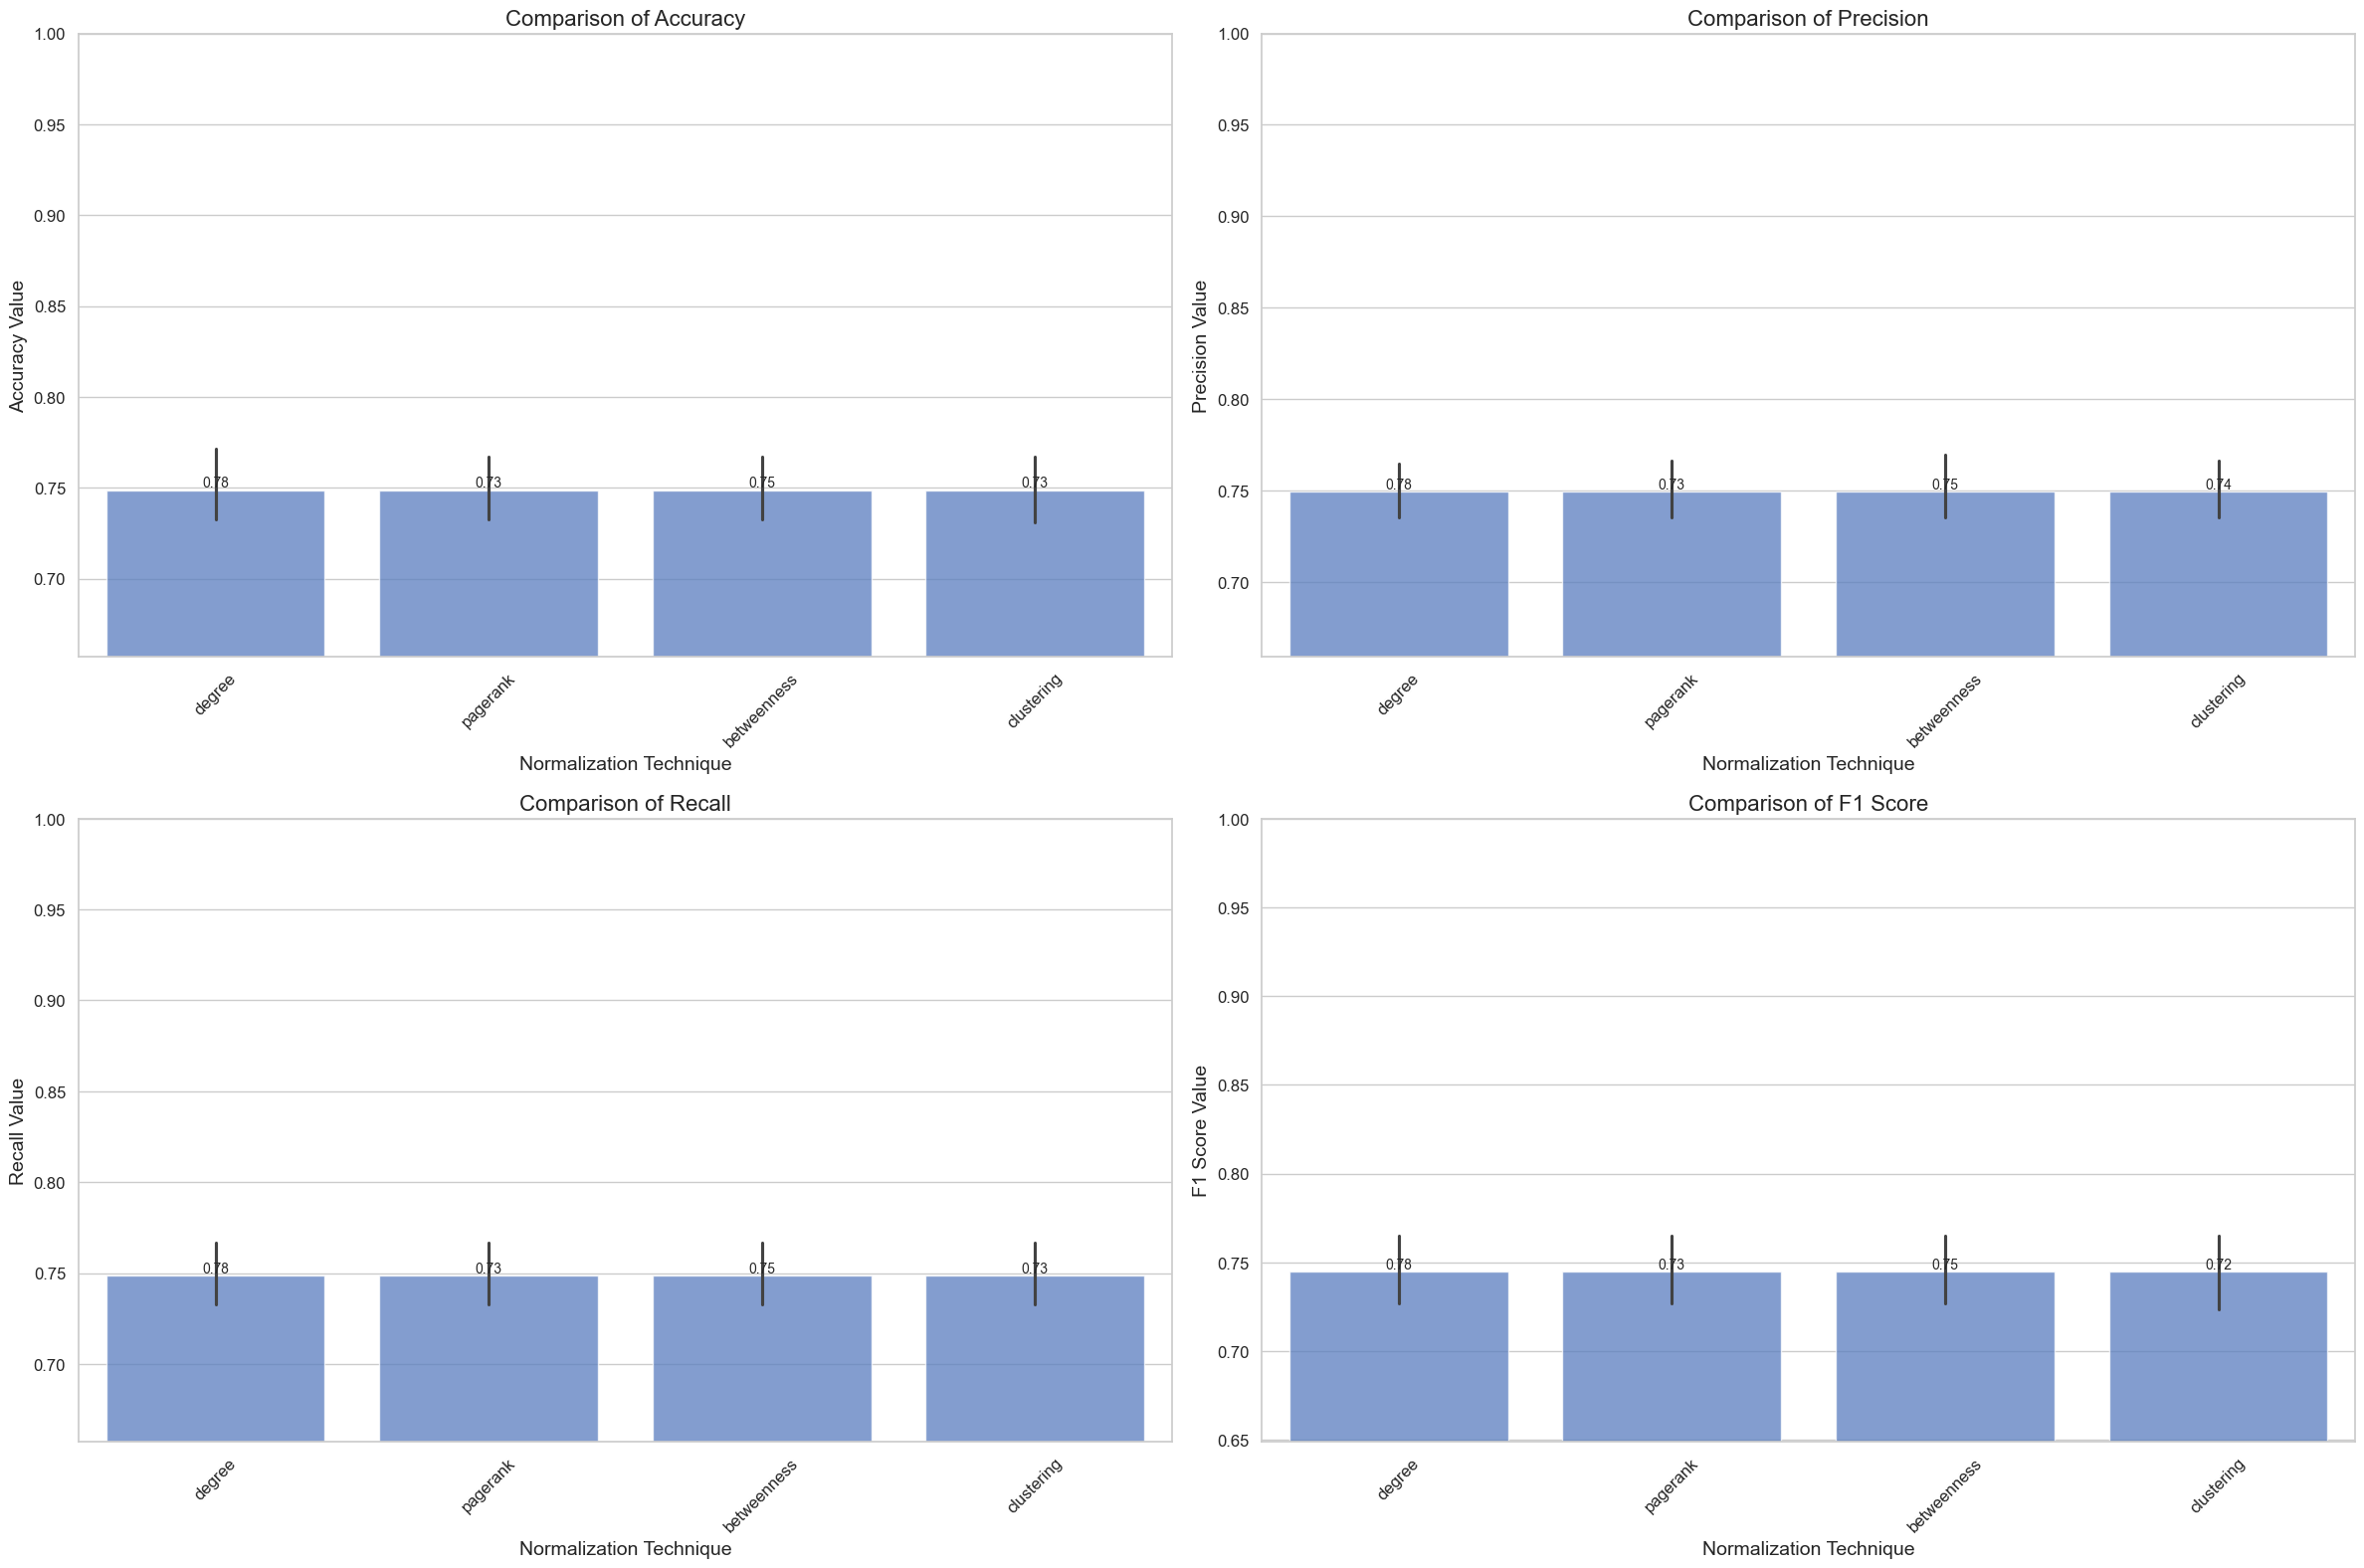


Extracting embeddings for model trained with degree normalization...

Extracting embeddings for model trained with pagerank normalization...

Extracting embeddings for model trained with betweenness normalization...

Extracting embeddings for model trained with clustering normalization...


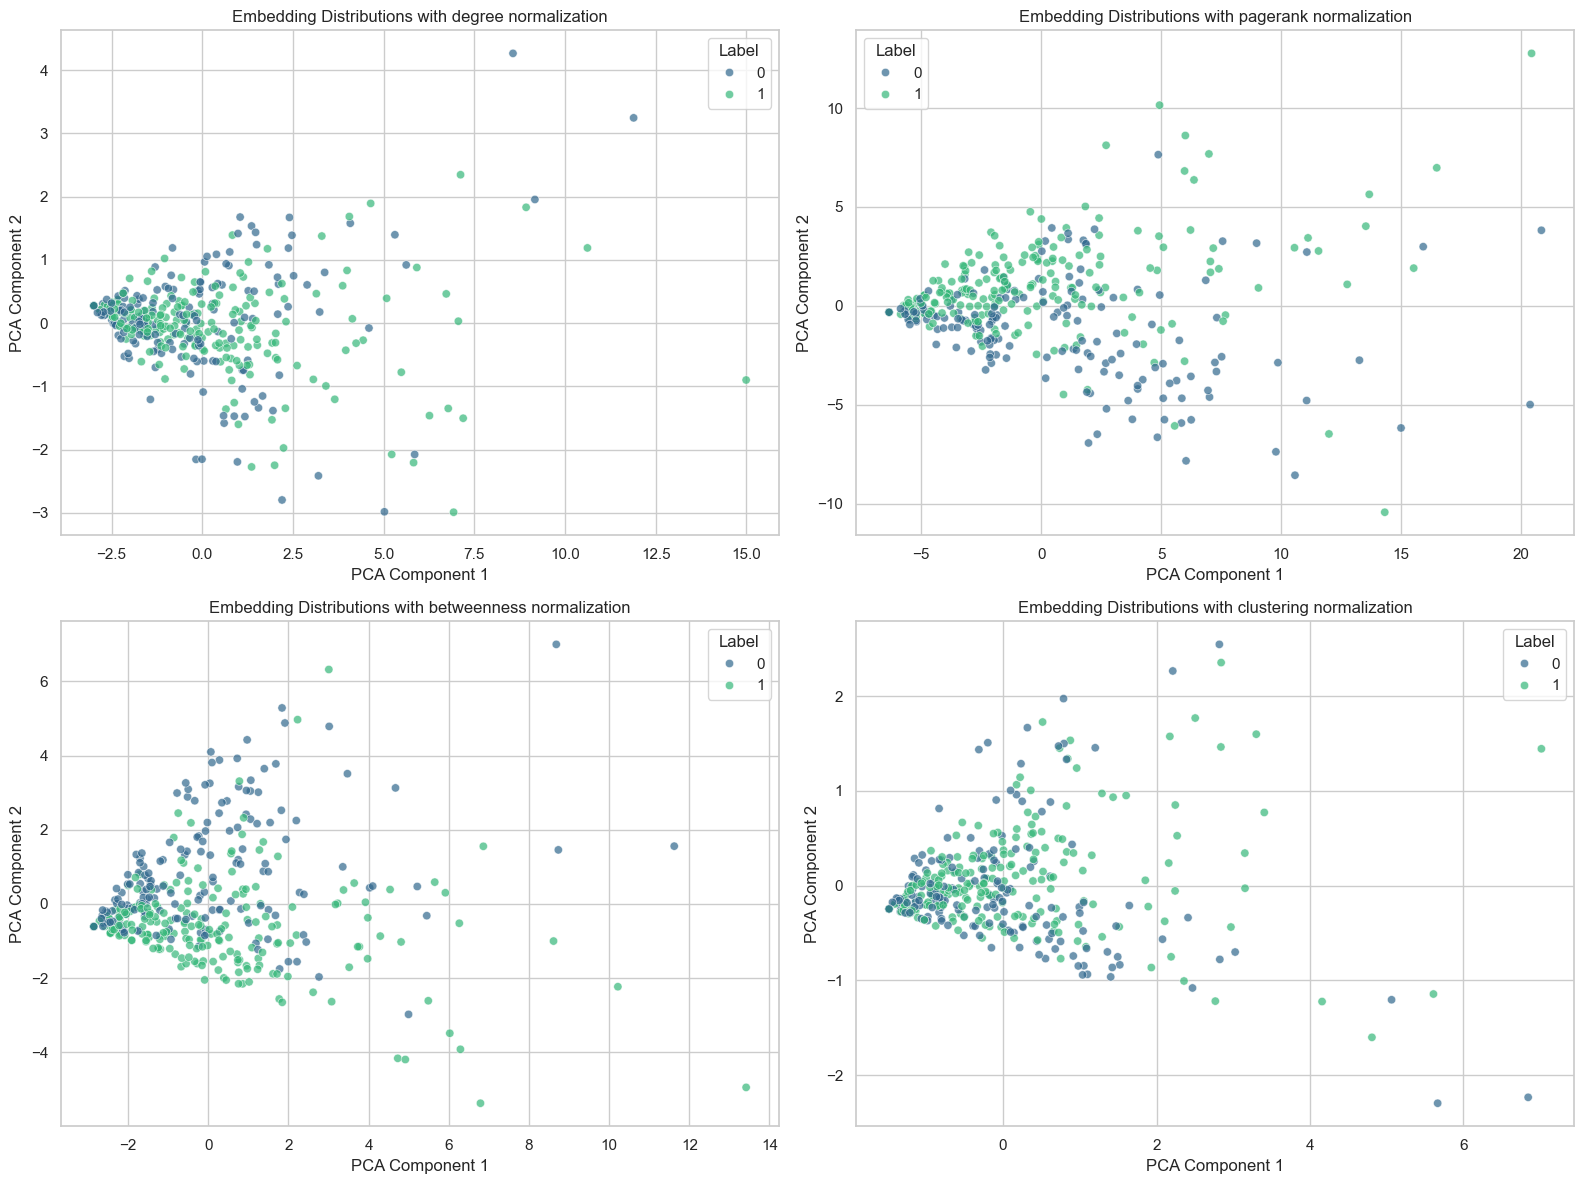

In [9]:
def main():
    """
    Main execution function to train and evaluate Graph Convolutional Network (GCN) models
    with different graph normalization techniques, visualize training metrics, and perform
    embedding analysis through PCA.

    Assumes the presence of a GCN model class, data loader preparation functions, and
    various normalization technique functions defined outside this script.
    """
    # Configuration parameters
    num_samples_per_type = 1000  # Number of samples per class/type
    num_epochs = 200  # Number of training epochs
    # Dictionary mapping normalization technique names to their corresponding functions
    normalization_techniques = {
        'degree': compute_degree_matrix_normalization,
        'pagerank': compute_pagerank_normalization,
        'betweenness': compute_betweenness_normalization,
        'clustering': compute_clustering_coefficient_normalization,
    }

    # Lists for storing evaluation metrics and model information
    metric_values = [[] for _ in range(4)]  # Lists to store Accuracy, Precision, Recall, F1 Score
    normalization_names = []  # Names of the normalization techniques
    train_losses_list = []  # Training loss values for each normalization technique
    models = []  # Trained models

    # Set the computation device (GPU or CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Loop over each normalization technique to train and evaluate a model
    for name, norm_func in normalization_techniques.items():
        print(f"\nTraining model with {name} normalization...")
        # Prepare data loaders
        train_loader, test_loader = prepare_data_loaders(num_samples_per_type, normalization_func=norm_func, batch_size=50)
        print(f"DataLoader batch size: {train_loader.batch_size}")

        # Initialize the GCN model, optimizer, and loss criterion
        model = GCN(nfeat=3, nhid=16, nclass=2).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        # Train the model
        train_losses = train_model(model, train_loader, optimizer, criterion, epochs=num_epochs, device=device)
        train_losses_list.append(train_losses)

        # Store the trained model
        models.append(model)

        # Evaluate the model's performance
        accuracy, precision, recall, f1 = evaluate_model(model, test_loader, device=device)
        # Store the evaluation metrics
        metric_values[0].append(accuracy)
        metric_values[1].append(precision)
        metric_values[2].append(recall)
        metric_values[3].append(f1)
        normalization_names.append(name)

        # Output the evaluation results
        print(f"Results with {name} normalization - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # Visualization of training losses and evaluation metrics for each normalization technique
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    plot_training_losses(train_losses_list, normalization_names)
    plot_metric_bar_charts(normalization_names, metric_values, metric_names)

    # Embedding extraction and PCA visualization
    embeddings_list = []
    labels_list = []  # Labels for each set of embeddings
    titles = []  # Titles for the PCA plots

    # Extract embeddings and labels for each model
    for name, model in zip(normalization_names, models):
        print(f"\nExtracting embeddings for model trained with {name} normalization...")
        embeddings, labels = extract_embeddings(model, test_loader, device=device)
        embeddings_list.append(embeddings)
        labels_list.append(labels)  # Append corresponding labels
        titles.append(f"Embedding Distributions with {name} normalization")

    # Apply PCA and visualize the embeddings
    apply_pca_and_visualize_all_sns(embeddings_list, titles, labels_list)

if __name__ == "__main__":
    main()

# Discussion

The embedding distributions with each normalisation are roughly the same shape, although magnitudes differ if you inspect the axes closely. While pagerank and clustering normalisations show a weak positive association between PCA1 and PCA2 for label 1 (i.e. in general green dots slope upwards) and the reverse is true for label 2, what is interesting is that for degree and betweenness normalisation, this appears to reverse. 

With respect to learning, all normalisations appear to exhibit a smooth loss function, implying that they have performed their job well of smoothing the topology of the loss function and avoiding shattered gradients.

Performance across normalisation techniques produce broadly similar results across all four metrics (accuracy, precision, recall, F1), all scoring between 70-75%.

# 2) Implementation of GraphSAGE with Node Sampling (30 points)

## 2.1) Dataset

In this question, we are going to train and test GraphSAGE on a **node classification** task using a toy Protein-Protein Interaction (PPI) dataset.

The dataset contains 24 graphs. The average number of nodes per graph is 2372. Each node has 50 features and 121 labels.

Since we will work on a node classification task, we will select only one of the graphs.

Below, we load the dataset and split into train/validation/test splits.

In [10]:
def load_ppi_data():
    # Load the dataset
    dataset = PPIDataset()

    # Select one graph from the PPI dataset
    g = dataset[0]

    # Extract features, labels
    features = g.ndata['feat']
    labels = g.ndata['label']

    num_nodes = g.number_of_nodes()
    num_train = int(0.6 * num_nodes)  # 60% for training
    num_val = int(0.2 * num_nodes)    # 20% for validation

    # Create a random permutation of node indices
    indices = torch.randperm(num_nodes)

    # Assign the first num_train nodes to the training set
    # Assign the next num_val nodes to the validation set
    # Assign the remaining nodes to the test set
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    train_mask[indices[:num_train]] = True
    val_mask[indices[num_train:num_train+num_val]] = True
    test_mask[indices[num_train+num_val:]] = True

    adj = g.adjacency_matrix().to_dense()

    return features, labels, adj, train_mask, val_mask, test_mask

In [11]:
features, labels, adj, train_mask, val_mask, test_mask = load_ppi_data()

features = features.to(device)
labels = labels.to(device)
adj = adj.to(device)

num_feats = features.shape[1]
num_classes = labels.shape[1]

# Convert one-hot encoding to class indices format
# e.g.,
# one-hot encoding vector [0, 0, 1, 0, 0, ....] is converted to class index 2.
# To use torch.nn.CrossEntropyLoss, we need to have this class indices format. 
# For more information, check https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
labels = torch.argmax(labels, dim=1)

train_features = features[train_mask]
val_features = features[val_mask]
test_features = features[test_mask]

train_labels = labels[train_mask]
val_labels = labels[val_mask]
test_labels = labels[test_mask]

train_adj = adj[train_mask][:, train_mask]
val_adj = adj[val_mask][:, val_mask]
test_adj = adj[test_mask][:, test_mask]

print(f"Number of train nodes: {train_adj.shape[0]}")
print(f"Number of val nodes: {val_adj.shape[0]}")
print(f"Number of test nodes: {test_adj.shape[0]}")
print(f"Number of features: {num_feats}")
print(f"Number of classes: {num_classes}")

Number of train nodes: 1060
Number of val nodes: 353
Number of test nodes: 354
Number of features: 50
Number of classes: 121


In [12]:
def compute_average_degree(A):
    degrees = A.sum(dim=1)  # Sum along rows to get degrees
    average_degree = degrees.mean().item()  # Compute the mean degree

    return average_degree

average_degree = compute_average_degree(train_adj)
print("Average Degree:", average_degree)

Average Degree: 12.305660247802734


## 2.2) Node-wise Sampling (15 points)
Node-wise sampling involves aggregating a subset of neighbors for each node in the graph, as opposed to considering all neighbors for aggregation (see the Figure 1). 

In the GraphSAGE, they sample a fixed number of neighbors in each layer. More specifically, they use $K=2$ number of layers and for the first layer and second layer, they sample $S_1=25$ and $S_2=10$ neighbors, respectively. 

**Here, for simplicity, we will sample $S=S_1=S_2=5$ neighbors for both layers**.

<img src="figures/nodewise_sampling.jpg" alt="Node-wise sampling" width="200" />

(Figure 1: Node-wise sampling<sup>1</sup>)

<sup>1</sup>_Hamilton, W., Ying, Z., & Leskovec, J. (2017). Inductive representation learning on large graphs. Advances in neural information processing systems, 30._


Below, you need to implement the sampler function. It takes the adj. matrix A and number of neighbors to sample, returns a list of lists including indices to sampled neighbors for each node in A.

You can use [torch.randperm](https://pytorch.org/docs/stable/generated/torch.randperm.html) or feel free to use any other function that does the same job.

In [13]:
def sampler(A, num_samples):
    """
    Samples "num_samples" amount of neighbors for each node in adj. matrix A
    You can use uniform random sampling. No need for any importance sampling strategy.

    Params:
        A (Tensor): Adj. matrix of shape (N x N)
        num_samples (int): Number of neighbors to sample for each node
        where N is the number of nodes.

    Returns:
        A list of lists including indices to sampled neighbors for each node in A.
    """

    N = A.shape[0]  # Number of nodes
    sampled_neighbors = []    

    ########## YOUR CODE HERE ##########
    neighbours_list = [torch.nonzero(A[i] == 1).squeeze(1).tolist() for i in range(N)]
    sampled_neighbors = [neighbours if len(neighbours) < num_samples else random.sample(neighbours, num_samples) for neighbours in neighbours_list] 
    ####################################

    return sampled_neighbors

Let's see the sampled neighbors for the first 10 nodes.

In [14]:
# set num_samples to 2 just for now
num_samples = 2

sampled_neighbors = sampler(adj[:10], num_samples)

# Print the sampled neighbors for each node
for node, neighbors in enumerate(sampled_neighbors):
    print(f"Node {node}: Sampled Neighbors {neighbors}")

Node 0: Sampled Neighbors [0, 1101]
Node 1: Sampled Neighbors [1194, 248]
Node 2: Sampled Neighbors [408, 1449]
Node 3: Sampled Neighbors [46, 100]
Node 4: Sampled Neighbors [161, 1177]
Node 5: Sampled Neighbors [5, 563]
Node 6: Sampled Neighbors [748, 6]
Node 7: Sampled Neighbors [7, 164]
Node 8: Sampled Neighbors [136, 1277]
Node 9: Sampled Neighbors [1435, 9]


## 2.3) Implementation of GraphSAGE (15 points)

In Figure 2, you can find the pseudo-code for the forward propagation of GraphSAGE. Basically, in each layer, GraphSAGE iterates over all the nodes in the graph and aggregates the neighborhood information from a set of sampled neighbors. Then, different from the original GCN model<sup>2</sup>, the embedding of the current node is concatenated with the aggregated embedding, doubling the size of the embedding vector before applying linear transformation via the learnable parameter $W^k$. After that, the embedding of the current node is updated following the application of a non-linearity.

They use different AGGREGATE functions such as mean and max-pooling aggregation. In this question, you need to use mean aggregation.

We choose the number of layers as $K=2$ and non-linearity as $ReLU$.

It is OK to skip the normalization in the line 7.

<img src="figures/graphsage_algo.jpg" alt="GraphSAGE Algorithm" width="700" />

(Figure 2: Forward propagation of GraphSAGE<sup>3</sup>)

<sup>2</sup>*Kipf, T. N., & Welling, M. (2016). Semi-supervised classification with graph convolutional networks. arXiv preprint arXiv:1609.02907.*

<sup>3</sup>*Liu, X., Yan, M., Deng, L., Li, G., Ye, X., & Fan, D. (2021). Sampling methods for efficient training of graph convolutional networks: A survey. IEEE/CAA Journal of Automatica Sinica, 9(2), 205-234.*



In [15]:
class GraphSAGEConvLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GraphSAGEConvLayer, self).__init__()
        ########## YOUR CODE HERE ##########
        # Define the learnable parameter W to be used in linear transformation
        # Take into account the dimension increase resulting from the concatenation
        # of the aggregated neighbor embeddings with the current node embedding.
        self.W = torch.nn.Parameter(torch.empty(input_dim*2, output_dim, dtype=torch.float32))
        torch.nn.init.xavier_uniform_(self.W)
        ####################################

    def forward(self, curr_node_emb, neighbor_embs):
        """
        Forward pass of a single GraphSAGE convolution layer

        Params:
        curr_node_emb (Tensor): Embedding vector of the current node.
        neighbor_embs (Tensor): Embedding vectors of sampled neighbors of the current node

        Returns:
        Tensor: New embedding of the current node
        """
        
        ########## YOUR CODE HERE ##########
        # 1. Aggregate neighbor embeddings using mean aggregation
        aggregated_embs = torch.mean(neighbor_embs, axis = 0)
        # 2. Concatenate the aggregated embeddings with the embedding of the current node
        # Ensure curr_node_emb is 2D
        if curr_node_emb.dim() == 1:
            curr_node_emb = curr_node_emb.unsqueeze(0)
        # Ensure aggregated_embs is 2D
        if aggregated_embs.dim() == 1:
            aggregated_embs = aggregated_embs.unsqueeze(0)
        embeddings = torch.cat((curr_node_emb, aggregated_embs), dim=1)
        # 3. Apply linear transformation using self.W
        linear_trans = torch.matmul(embeddings, self.W) 
        # 4. Apply ReLU non-linearity
        new_embedding = F.relu(linear_trans)
        # 5. Return the new_embedding
        return new_embedding
        ####################################


class GraphSAGE(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_samples):
        super(GraphSAGE, self).__init__()
        self.layers = nn.ModuleList([
            GraphSAGEConvLayer(input_dim, hidden_dim),
            GraphSAGEConvLayer(hidden_dim, num_classes)
        ])
        self.num_samples = num_samples

    def forward(self, X, A):
        """
        Forward pass of GraphSAGE

        Params:
        X (Tensor): Node feature matrix of shape (N x d)
        A (Tensor): Adj. matrix of shape (N x N)
        where N is the number of nodes and d is the embedding size.

        Returns:
        Tensor: The output matrix of the last layer with shape (N x num_classes)
        """

        ########## YOUR CODE HERE ##########
        # Placeholder for updated embeddings; initially set to input features
        current_embs = X
        for layer in self.layers:
            # Sample the neighbors for each node in this layer
            sampled_neighbors = sampler(A, self.num_samples)

            # Next, update the embedding for each node
            new_embs = []
            for node in range(A.size(0)):
                # Get the indices of the sampled neighbors
                neighbors_idx = sampled_neighbors[node]
                # Extract embeddings of the sampled neighbors
                if neighbors_idx:  # Check if there are neighbors
                    neighbor_embs = current_embs[neighbors_idx]
                else:
                    neighbor_embs = torch.zeros_like(current_embs[node]).unsqueeze(0)
                # Forward pass through the layer for the current node
                node_emb = layer(current_embs[node].unsqueeze(0), neighbor_embs)
                new_embs.append(node_emb)
            
            # Update embeddings for the next layer
            current_embs = torch.cat(new_embs, dim=0)
        return current_embs
        # 1. For each layer:
        #   1.1. Sample neighbors using the sampler function and adj matrix A 
        #   1.2. Update the embedding for each node
        #     1.2.1 Forward pass through the GraphSAGE convolution layer
        #     1.2.2 Store the new embeddings for each node
        #   1.3. Update the node feature matrix for the next layer
        # 2. Return the final node feature matrix with shape (N x num_classes)
        ####################################

In [16]:
def trainStepGraphSAGE(model, features, adj, labels, loss_fn, optimizer):
    model.train()

    # Forward pass
    logits = model(features, adj)
    train_loss = loss_fn(logits, labels)

    # Backward pass and optimization
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    return train_loss.item()

In [17]:
@torch.no_grad()
def testGraphSAGE(model, features, adj, labels):
    model.eval()
    logits = model(features, adj)

    _, predicted = torch.max(logits, 1)

    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total

    return accuracy

In [18]:
def trainGraphSAGE(model, train_features, val_features, train_adj, val_adj, train_labels, val_labels, num_epochs=50):
    t = time.time()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.01)

    best_model = None
    best_valid_acc = 0

    for epoch in range(1, 1 + num_epochs):
        train_loss = trainStepGraphSAGE(model, train_features, train_adj, train_labels, loss_fn, optimizer)
        val_acc = testGraphSAGE(model, val_features, val_adj, val_labels)
        if val_acc > best_valid_acc:
            best_valid_acc = val_acc
            best_model = copy.deepcopy(model)
        
        print(f'Epoch: {epoch:02d}, '
            f'Train Loss: {train_loss:.4f}, ',
            f'Validation Accuracy: {100*val_acc:.4f}%, ',
            f'time: {time.time() - t:.4f}s.')
    
    print(f'best acc_valid: {100*best_valid_acc:.4f}%')

    return best_model

In [19]:
# feel free to play with hidden_dim :)
hidden_dim = 64
model = GraphSAGE(num_feats, hidden_dim, num_classes, num_samples=5)

model.to(device)

GraphSAGE(
  (layers): ModuleList(
    (0-1): 2 x GraphSAGEConvLayer()
  )
)

In [22]:
best_model = trainGraphSAGE(model, train_features, val_features, train_adj, val_adj, train_labels, val_labels, num_epochs=50)

Epoch: 01, Train Loss: 0.6821,  Validation Accuracy: 69.6884%,  time: 0.5296s.
Epoch: 02, Train Loss: 0.7083,  Validation Accuracy: 75.3541%,  time: 1.0569s.
Epoch: 03, Train Loss: 0.6922,  Validation Accuracy: 74.5042%,  time: 1.5917s.
Epoch: 04, Train Loss: 0.6631,  Validation Accuracy: 71.1048%,  time: 2.0471s.
Epoch: 05, Train Loss: 0.6685,  Validation Accuracy: 69.6884%,  time: 2.5205s.
Epoch: 06, Train Loss: 0.6648,  Validation Accuracy: 69.9717%,  time: 3.0178s.
Epoch: 07, Train Loss: 0.6491,  Validation Accuracy: 71.6714%,  time: 3.4899s.
Epoch: 08, Train Loss: 0.6319,  Validation Accuracy: 73.3711%,  time: 3.9520s.
Epoch: 09, Train Loss: 0.6264,  Validation Accuracy: 73.3711%,  time: 4.4169s.
Epoch: 10, Train Loss: 0.6278,  Validation Accuracy: 71.3881%,  time: 4.8869s.
Epoch: 11, Train Loss: 0.6130,  Validation Accuracy: 71.9547%,  time: 5.3545s.
Epoch: 12, Train Loss: 0.6053,  Validation Accuracy: 69.9717%,  time: 5.8366s.
Epoch: 13, Train Loss: 0.5927,  Validation Accuracy:

In [21]:
# You should get around 70-75% test accuracy.
test_acc = testGraphSAGE(best_model, test_features, test_adj, test_labels)
print(f"Test Accuracy: {100*test_acc:.4f}%")

Test Accuracy: 68.3616%


# 3) Attention-based aggregation in node classification (30 points)

The objective is to develop two types of aggregation methods: mean aggregation and aggregation by attention.

For those who require additional guidance or clarification, it is recommended to revisit the relevant [lecture](https://www.youtube.com/watch?v=zRmzVkidkqA&list=PLug43ldmRSo14Y_vt7S6vanPGh-JpHR7T&index=13) or consult the course [notes](https://drive.google.com/file/d/1p7U1xyW4-5W4ge8gRstUkBGQSY3fKHX6/view).


Important Reminder: Please ensure that you execute all the cells in each section in sequence to maintain the integrity of intermediate variables and package imports.




## Constructing Layers for Graph Neural Networks (17 points)


Let's begin by creating a dummy dataset that will aid in the development and testing of our Graph Neural Networks (GNNs). This dataset will include a simple graph structure with defined nodes, edges, and node features.

In [23]:
def create_dummy_data(n_nodes, n_features):
  # Create a random adjacency matrix for an undirected graph
  # Use a random integer matrix and make it symmetric
  adj = torch.triu(torch.randint(0, 2, (n_nodes, n_nodes)), diagonal=1)
  adj = adj + adj.T

  # Create random features for each node
  adj = adj.type(torch.float)
  x = torch.rand(n_nodes, n_features)

  return x, adj

In [24]:
x, adj = create_dummy_data(5, 3)
print(x.shape)
print(adj.shape)

torch.Size([5, 3])
torch.Size([5, 5])


### Building a Graph Neural Network with Mean Aggregation (7 points)

Observe that the GNN utilizing a mean aggregator is significantly influenced by how the adjacency matrix is normalized.

The formula for the next layer's node representations is given by:

$H_{k+1} = a[\beta_k\mathbf{1}^T + \Omega_kH_k(AD^{-1}+I)]$

We will proceed to implement the mean normalization of the adjacency matrix using the following expression:

$\widetilde{A}=AD^{-1}+I$


In [25]:
def mean_normalization(A):
  ############# Your code here ############
    D = np.diag(A.sum(dim=1)) # 1. Calculate the degree matrix
    D_inv = torch.inverse(torch.tensor(D)) # 2. Create the inverse of the degree matrix
    A_tilda = torch.matmul(A, D_inv) + torch.eye(A.shape[0]) # 3. Compute the mean normalization of the adjacency matrix
  #########################################
    return A_tilda

In [26]:
## Test your implementation to observe the behavior of the
## mean normalization adjacency matrix.
## Note:
## It should reflect the values normalized over the number of neighbors,
## with the inclusion of a self-loop for each node
mean_normalization(adj)

tensor([[1.0000, 0.3333, 0.3333, 0.0000, 0.0000],
        [0.5000, 1.0000, 0.3333, 0.3333, 0.0000],
        [0.5000, 0.3333, 1.0000, 0.3333, 0.0000],
        [0.0000, 0.3333, 0.3333, 1.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.3333, 1.0000]])

Now, let's build the GCN layer with a mean aggregator. Remeber, node features are computed as follows:

$H_{k+1} = a[\beta_k\mathbf{1}^T + \Omega_kH_k(AD^{-1}+I)]$

In [27]:
class GCN(nn.Module):
    """
    A basic implementation of GCN layer.
    It aggregates information from a node's neighbors
    using mean aggregation.
    """
    def __init__(self, in_features, out_features, activation=None):
        super(GCN, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.bias = nn.Parameter(torch.zeros(out_features))
        self.activation = activation
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / np.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)

    def forward(self, x, adj):
        """
        Forward pass of the GCN layer.

        Parameters:
        input (Tensor): The input features of the nodes.
        adj (Tensor): The adjacency matrix of the graph.

        Returns:
        Tensor: The output features of the nodes after applying the GCN layer.
        """
        adj_norm = mean_normalization(adj)
        ############# Your code here ############
        linear_transformation = torch.matmul(x, self.weight) # 1. Apply the linear transformation
        output = torch.matmul(adj_norm, linear_transformation) + self.bias # 2. Perform the graph convolution operation
        #########################################
        h = self.activation(output) if self.activation else output
        return h

In [28]:
## Ensure that your implementation is flexible enough to accommodate changes
## in the number of hidden features. Verify that the dimensions of all
## matrices are correctly aligned, allowing for a successful forward
## pass through the network.
GCN(x.size(1), 3)(x, adj)

tensor([[ 0.0651, -0.8226,  0.9991],
        [-0.0478, -0.9909,  1.0584],
        [ 0.0282, -1.0742,  1.1919],
        [ 0.0906, -0.8872,  0.5604],
        [ 0.0943, -0.4131,  0.0672]], grad_fn=<AddBackward0>)

### Developing a Graph Neural Network with Attention-Based Aggregation (10 points)

The transformed node embeddings $H_k^{'}$ are calculated using the formula:

\begin{equation}
H_k^{'} = \beta_k\mathbf{1}^T + \Omega_kH_k
\end{equation}

In this equation, $\beta_k$ and $\Omega_k$ are parameters, and $H_k$ represents the node embeddings at layer $k$.

To compute the similarity $s_{mn}$ between any two transformed node embeddings $h^{'}_m$ and $h^{'}_n$, we concatenate these embeddings and then take a dot product with a learned parameter vector $\phi_k$. An activation function is then applied to this dot product:

\begin{equation}
s_{mn} = a\left[\phi_k^T \begin{bmatrix} h^{'}_m\\ h^{'}_n \end{bmatrix}\right]
\end{equation}

These similarity values are organized into an $N \times N$ matrix $S$, where each element represents the similarity between every pair of nodes.

The attention weights that contribute to each output embedding are normalized to ensure they are positive and sum to one.

This normalization is achieved using the softmax operation. However, it's important to note that only the values corresponding to a node and its neighbors are considered in this computation. The attention weights are then applied to the transformed embeddings as follows:

\begin{equation}
a[H_k^{'} * \text{Softmax}(S, A+I)]
\end{equation}

Here, $A+I$ represents the adjacency matrix with added self-loops, ensuring that each node also considers itself when computing attention weights.


To get started, it's important to grasp how to calculate the similarity matrix.

A straightforward approach would be to iterate through all the nodes and compute the similarity scores for each pair.

In [29]:
N = x.size(0)
D = 3

# Initialize H' and phi with random values
H = torch.rand(size=(N, D))
phi = torch.rand(size=(2 * D,))

# Initialize the similarity matrix S
S = torch.zeros((N, N))

# Loop over all nodes to compute the similarity scores
for i in range(N):
    for j in range(N):
        ############# Your code here ############
        cat_features = torch.cat((H[i], H[j])) # 1. Concatenate the features of nodes i and j
        S[i, j] = torch.dot(phi, cat_features) # 2. Compute the dot product of concatenated features with phi
        #########################################
print(S)

tensor([[2.1452, 1.7905, 2.0233, 1.8662, 1.7590],
        [1.6957, 1.3410, 1.5739, 1.4168, 1.3095],
        [1.9914, 1.6367, 1.8695, 1.7124, 1.6052],
        [1.8412, 1.4866, 1.7194, 1.5623, 1.4550],
        [1.6652, 1.3105, 1.5433, 1.3862, 1.2789]])


It's crucial to apply a mask to the pre-attention scores before they are processed through the softmax function. This ensures that the normalization is applied exclusively to the existing edges in the graph, maintaining the integrity of the graph structure.


Construct the mask using the following equation:
$mask = A+I$

In [30]:
############# Your code here ############
## contruct the mask, name it `mask`
## return a boolean matrix NxN
## (1 line of code)
mask = adj + torch.eye(adj.shape[0])
#########################################
print(mask)

tensor([[1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1.]])


Apply the mask to the pre-attention
$S[mask]$.

Set $S$ to very large negative values. This is effectively to represent negative infinity in the context of the softmax operation that follows.

In [31]:
############# Your code here ############
## get masked values for S, `S_masked`
## hint: see torch.where
## Note: The values masked should effectively be zero,
## considering the limits of numerical precision.
S_masked = torch.where(mask == True, S, -1e10)  
#########################################
print(S_masked.exp())

tensor([[8.5436, 5.9925, 7.5634, 0.0000, 0.0000],
        [5.4506, 3.8230, 4.8252, 4.1238, 0.0000],
        [7.3256, 5.1382, 6.4851, 5.5424, 0.0000],
        [0.0000, 4.4219, 5.5811, 4.7698, 4.2846],
        [0.0000, 0.0000, 0.0000, 3.9997, 3.5928]])



Now, let's proceed to implement the Graph Attention Network (GAT). The preparatory work we've done should have provided you with all the necessary tools and understanding to successfully implement the attention based aggregation.

In [32]:
class GAT(nn.Module):
    """
    A basic implementation of the GAT layer.

    This layer applies an attention mechanism in the graph convolution process,
    allowing the model to focus on different parts of the neighborhood
    of each node.
    """
    def __init__(self, in_features, out_features, activation=None):
        super(GAT, self).__init__()
        # Initialize the weights, bias, and attention parameters as
        # trainable parameters
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.bias = nn.Parameter(torch.zeros(out_features))
        self.phi = nn.Parameter(torch.FloatTensor(2 * out_features, 1))
        self.activation = activation
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / np.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)

        stdv = 1. / np.sqrt(self.phi.size(1))
        self.phi.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        """
        Forward pass of the GAT layer.

        Parameters:
        input (Tensor): The input features of the nodes.
        adj (Tensor): The adjacency matrix of the graph.

        Returns:
        Tensor: The output features of the nodes after applying the GAT layer.
        """
        ############# Your code here ############
        H = input @ self.weight + self.bias.unsqueeze(0) # 1. Apply linear transformation and add bias
        N = H.size(0)
        H_expanded = H.unsqueeze(1).expand(N, N, -1)
        H_pairs = torch.cat((H_expanded, H_expanded.transpose(0, 1)), dim=2)
        S = torch.matmul(H_pairs, self.phi).squeeze(-1) # 2. Compute the attention scores
        mask = adj + torch.eye(adj.shape[0])  # 3. Compute mask based on adjacency matrix
        S_masked = torch.where(mask == True, S, torch.tensor(-1e10)) # 4. Apply mask to the pre-attention matrix
        attention_weights = F.softmax(S_masked, dim = 1) # 5. Compute attention weights using softmax
        h = torch.matmul(attention_weights, H) # 6. Aggregate features based on attention weights
        #############################################
        return self.activation(h) if self.activation else h


In [33]:
## Ensure that your implementation is flexible enough to accommodate changes
## in the number of hidden features. Verify that the dimensions of all
## matrices are correctly aligned, allowing for a successful forward
## pass through the network.
GAT(x.size(1), 3).to(device)(x, adj)

tensor([[-0.0891,  0.0915, -0.3899],
        [-0.0737,  0.0663, -0.2975],
        [-0.0737,  0.0663, -0.2975],
        [-0.0710,  0.1809, -0.2186],
        [-0.0603,  0.2027, -0.0574]], grad_fn=<MmBackward0>)

## Node Classification (6 points)

Here is a GNN for node classification

In [34]:
class NodeClassifier(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout, gnn_layer):
        super(NodeClassifier, self).__init__()

        self.gc1 = gnn_layer(nfeat, nhid, F.relu)
        self.gc2 = gnn_layer(nhid, nclass, None)
        self.dropout = dropout

    def forward(self, x, adj):
        x = self.gc1(x, adj)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)

Let's get hands-on experience by loading a benchmark dataset - the Cora dataset.

Dataset: Cora is a widely-used benchmark in graph ML. It consists of a citation network where nodes represent scientific papers, and edges correspond to citations between these papers. Each paper (node) is described by a textual abstract and is categorized into one of several classes based on its content.

Node Classification: we'll dive into  node classification where the goal is to predict the category of each paper in the Cora citation network.

In [35]:
def load_cora_data(subset_size=100):
    # Load the dataset
    dataset = CoraGraphDataset()
    g = dataset[0]
    if subset_size > 0:
      # Ensure subset_size is smaller than the total number of nodes
      total_nodes = g.num_nodes()
      subset_size = min(subset_size, total_nodes)

      # Select a subset of nodes
      subset_nodes = torch.randperm(total_nodes)[:subset_size]

      # Create a subgraph with the selected nodes
      subg = g.subgraph(subset_nodes)
    else:
      subg = g

    # Extract features, labels, and masks for the graph
    features = subg.ndata['feat']
    labels = subg.ndata['label']
    train_mask = subg.ndata['train_mask']
    val_mask = subg.ndata['val_mask']
    test_mask = subg.ndata['test_mask']

    adj = subg.adjacency_matrix().to_dense()

    return features, labels, adj, train_mask, val_mask, test_mask
features, labels, adj, train_mask, val_mask, test_mask = load_cora_data(-1)

features = features.to(device)
labels = labels.to(device)
adj = adj.to(device)
train_mask = train_mask.to(device)
val_mask = val_mask.to(device)
test_mask = test_mask.to(device)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


Feel free to analyze and print the dimensions of *features, adj*, and *labels*. This will help you debug in case of errors.

Note: you can take a subset of the full graph `load_cora_data(subset_size=1000)` to spead up development. However, we expect the final submission on the full graph

Let's define metrics to track

In [36]:
def calculate_specificity(y_true, y_pred, labels):
    specificity_scores = np.zeros(len(labels))
    for i, label in enumerate(labels):
        binary_true = (y_true == label).int()
        binary_pred = (y_pred == label).int()

        tn, fp, fn, tp = confusion_matrix(binary_true, binary_pred).ravel()

        specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
        specificity_scores[i] = specificity

    return np.mean(specificity_scores)

In [37]:
def compute_accuracy(target, prediction):
  ############# Your code here ############
    correct_predictions = (target == prediction).int().sum() # 1. Count the number of correct predictions
    N_predictions = target.shape[0] # 2. Get the total number of predictions
    accuracy = correct_predictions.float()/N_predictions # 3. Calculate the accuracy
  #########################################
    return accuracy

In [38]:
sensitivity = lambda y_true, y_pred: recall_score(y_true, y_pred, average='macro')
specificity = lambda y_true, y_pred: calculate_specificity(y_true, y_pred, labels.unique())
accuracy = lambda y_true, y_pred: compute_accuracy(y_true, y_pred)

Almost there, write the main training function to train our GNNs.

In [39]:
def train_step(model, X, A, y ,train_mask, optimizer, loss_fn):
  model.train()
  loss = 0
  ############# Your code here ############
  optimizer.zero_grad() # 1. Zero grad the optimizer
  output = model(X, A) # 2. Feed the data into the model
  output_train = output[train_mask]
  y_train = y[train_mask] # 3. Slice the model output and label by train_mask
  loss = loss_fn(output_train, y_train) # 4. Feed the sliced output and label to loss_fn
  #########################################

  loss.backward()
  optimizer.step()

  return loss.item()

In [40]:
@torch.no_grad()
def test(model, X, A, y, train_mask, val_mask, test_mask=None, metrics={}):
  model.eval()

  # The output of model on all data
  out = None
  logits = model(X, A)
  preds = logits.argmax(dim=1)

  result = {
        'train': {},
        'val': {},
      }
  if test_mask is not None:
    result['test'] = {}

  for name, metric in metrics.items():
    result['train'][name] = metric(y[train_mask], preds[train_mask])
    result['val'][name] = metric(y[val_mask], preds[val_mask])

    if test_mask is not None:
      result['test'][name] = metric(y[test_mask], preds[test_mask])

  return result

In [41]:
def train(model, epochs, lr):
  t = time.time()
  optimizer = torch.optim.Adam(model.parameters(),
                            lr=lr,
                            weight_decay=5e-4)
  loss_fn = F.nll_loss
  metrics = {"acc": accuracy}

  best_model = None
  best_valid_acc = 0

  for epoch in range(1, 1 + epochs):
    loss = train_step(model, features, adj, labels, train_mask,
                      optimizer, loss_fn)


    result = test(model, features, adj, labels,
                train_mask, val_mask, None, metrics)
    train_acc = result['train']['acc']
    valid_acc = result['val']['acc']
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_model = copy.deepcopy(model)
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {loss:.4f}, ',
          f'acc_train: {100*train_acc:.4f}%, ',
          f'acc_valid: {100*valid_acc:.4f}%, ',
          f'time: {time.time() - t:.4f}s.')
  print(f'best acc_valid: {100*best_valid_acc:.4f}%')
  return best_model

Execute node classification on the Cora dataset using mean aggregation.



In [42]:
## Note:
## feel free to play with the parameters to improve validation accuracy
## you should get a validationaccuracy of at least 77%-80%
model_GCN = NodeClassifier(nfeat=features.shape[1],
                  nhid=32,
                  nclass=labels.max().item() + 1,
                  dropout=0.8,
                  gnn_layer=GCN).to(device)
model_GCN = train(model_GCN, 60, 0.01) # Raise dropout and reduce epochs to prevent overfitting. Increase hidden dimension.

Epoch: 01, Loss: 1.9637,  acc_train: 30.7143%,  acc_valid: 17.2000%,  time: 0.9937s.
Epoch: 02, Loss: 1.9168,  acc_train: 45.7143%,  acc_valid: 19.4000%,  time: 1.9628s.
Epoch: 03, Loss: 1.8923,  acc_train: 58.5714%,  acc_valid: 26.8000%,  time: 3.0281s.
Epoch: 04, Loss: 1.8456,  acc_train: 68.5714%,  acc_valid: 33.0000%,  time: 4.1081s.
Epoch: 05, Loss: 1.8015,  acc_train: 79.2857%,  acc_valid: 39.6000%,  time: 5.1321s.
Epoch: 06, Loss: 1.7575,  acc_train: 83.5714%,  acc_valid: 46.0000%,  time: 6.1527s.
Epoch: 07, Loss: 1.6948,  acc_train: 90.0000%,  acc_valid: 53.0000%,  time: 7.2338s.
Epoch: 08, Loss: 1.6680,  acc_train: 90.7143%,  acc_valid: 57.8000%,  time: 8.2677s.
Epoch: 09, Loss: 1.5963,  acc_train: 91.4286%,  acc_valid: 60.8000%,  time: 9.3073s.
Epoch: 10, Loss: 1.5626,  acc_train: 92.1429%,  acc_valid: 63.0000%,  time: 10.3392s.
Epoch: 11, Loss: 1.5154,  acc_train: 94.2857%,  acc_valid: 66.0000%,  time: 11.3885s.
Epoch: 12, Loss: 1.4573,  acc_train: 95.7143%,  acc_valid: 68.6

Execute node classification on the Cora dataset using attention based aggregation.



In [46]:
## Note:
## feel free to play with the parameters to improve validation accuracy
## you should get a validationaccuracy of at least 77%-80%
model_GAT = NodeClassifier(nfeat=features.shape[1],
              nhid=24,
              nclass=labels.max().item() + 1,
              dropout=0.65,
              gnn_layer=GAT).to(device)
model_GAT = train(model_GAT, 60, 0.01) # slightly raise dropout and lower epochs to reduce overfitting to train

Epoch: 01, Loss: 1.9479,  acc_train: 27.8571%,  acc_valid: 30.6000%,  time: 1.2982s.
Epoch: 02, Loss: 1.9397,  acc_train: 49.2857%,  acc_valid: 31.6000%,  time: 2.5826s.
Epoch: 03, Loss: 1.9363,  acc_train: 65.0000%,  acc_valid: 42.0000%,  time: 3.8825s.
Epoch: 04, Loss: 1.9279,  acc_train: 72.8571%,  acc_valid: 47.0000%,  time: 5.1822s.
Epoch: 05, Loss: 1.9223,  acc_train: 79.2857%,  acc_valid: 53.4000%,  time: 6.4921s.
Epoch: 06, Loss: 1.9184,  acc_train: 85.7143%,  acc_valid: 59.0000%,  time: 7.7963s.
Epoch: 07, Loss: 1.9087,  acc_train: 86.4286%,  acc_valid: 64.8000%,  time: 9.1120s.
Epoch: 08, Loss: 1.8946,  acc_train: 87.1429%,  acc_valid: 67.6000%,  time: 10.5120s.
Epoch: 09, Loss: 1.8867,  acc_train: 87.1429%,  acc_valid: 62.6000%,  time: 11.8416s.
Epoch: 10, Loss: 1.8791,  acc_train: 85.7143%,  acc_valid: 61.8000%,  time: 13.2569s.
Epoch: 11, Loss: 1.8700,  acc_train: 86.4286%,  acc_valid: 62.6000%,  time: 14.5914s.
Epoch: 12, Loss: 1.8579,  acc_train: 87.8571%,  acc_valid: 64

## Visualize and analize results (7 points)


Familiarize yourself with the following utility functions, which are designed for visual analysis and will assist us in evaluating our GNNs.

In [47]:
def plot_embeddings(embeddings1, embeddings2, labels):
    # Convert multi-labels to unique integers for color-coding
    unique_labels, label_indices = np.unique(labels, axis=0, return_inverse=True)

    # Set up the matplotlib figure and axes
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Perform PCA for both sets of embeddings
    pca = PCA(n_components=2)
    pca_result1 = pca.fit_transform(embeddings1)
    pca_result2 = pca.fit_transform(embeddings2)

    # Plotting GCN
    scatter1 = axs[0].scatter(pca_result1[:, 0], pca_result1[:, 1], c=label_indices, cmap='viridis')
    axs[0].set_title('GCN')
    axs[0].set_xlabel('PCA Component 1')
    axs[0].set_ylabel('PCA Component 2')

    # Plotting GAT
    scatter2 = axs[1].scatter(pca_result2[:, 0], pca_result2[:, 1], c=label_indices, cmap='viridis')
    axs[1].set_title('GAT')
    axs[1].set_xlabel('PCA Component 1')
    axs[1].set_ylabel('PCA Component 2')

    # Create a color bar with label information
    cbar = plt.colorbar(scatter1, ax=axs, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('Label Combinations')
    cbar.set_ticks(np.arange(len(unique_labels)))
    cbar.set_ticklabels([' + '.join(str(comb)) for comb in unique_labels])

    # Show the plot
    plt.show()


In [48]:
def plot_weight_distributions(weights1, weights2):
    # Flatten the weight matrices
    flattened_weights1 = weights1.flatten()
    flattened_weights2 = weights2.flatten()

    # Create KDE plots
    plt.figure(figsize=(12, 6))
    sns.kdeplot(flattened_weights1, fill=True, color="r", label="GCN")
    sns.kdeplot(flattened_weights2, fill=True, color="b", label="GAT")

    plt.title("Distribution of GNN Weights")
    plt.xlabel("Weight Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()


In [49]:
def plot_metrics(metrics, title, phases = ['train', 'val', 'test']):
    n_phases = len(phases)

    # Setting up the subplot grid
    fig, axs = plt.subplots(n_phases, 1, figsize=(15, 6 * n_phases), sharey=True)

    for i, phase in enumerate(phases):
        # Extracting metric names
        metric_names = list(metrics[0][phase].keys())

        # Number of metrics
        n_metrics = len(metric_names)

        # Data for plotting
        scores_modelA = [metrics[0][phase][metric] for metric in metric_names]
        scores_modelB = [metrics[1][phase][metric] for metric in metric_names]

        # Setting the positions and width for the bars
        pos = np.arange(n_metrics)
        bar_width = 0.35

        # Plotting in the respective subplot
        axs[i].bar(pos - bar_width/2, scores_modelA, bar_width, label='GCN')
        axs[i].bar(pos + bar_width/2, scores_modelB, bar_width, label='GAT')

        # Adding labels and titles
        axs[i].set_xlabel('Metrics')
        axs[i].set_title(f'{phase.capitalize()} Metrics')
        axs[i].set_xticks(pos)
        axs[i].set_xticklabels(metric_names)

        # Adding a legend to the first subplot
        if i == 0:
            axs[i].legend()

    # Setting the main title and showing the plot
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### Node Embeddings

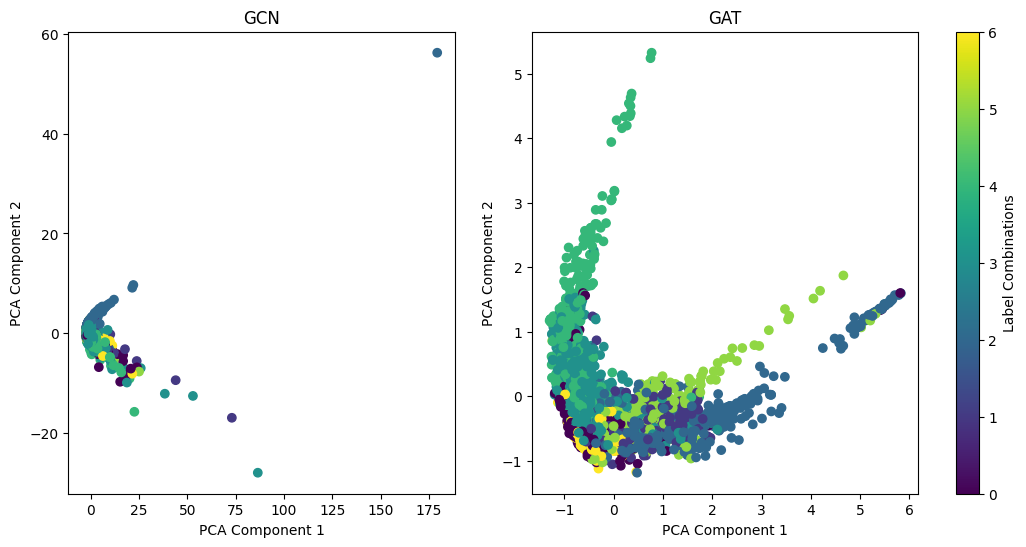

In [50]:
############# Your code here ############
## 1. Generate embeddings using the GCN model
model_GCN.eval() # Set to evaluation mode
with torch.no_grad(): # Disable gradient computation
    H_GCN = model_GCN(features, adj).detach().cpu().numpy()
## 2. Generate embeddings using the GAT model
model_GAT.eval() # Set to evaluation mode
with torch.no_grad(): # Disable gradient computation
    H_GAT = model_GAT(features, adj).detach().cpu().numpy()
## Note: use detach to avoid using the computation graph
## convert the tensor to a numpy array
## use H_GCN and H_GAT as variable names
## (~2 lines of code)
#########################################
plot_embeddings(H_GCN,H_GAT, labels)

Based on the visualizations in the plots, what insights can you gather about the embeddings generated by each model?

## Discussion

From the two plots, the embeddings appear clustered by label combination (the embeddings are somewhat grouped by colour). This implies that both models have learnt some disciminative features which can be helpful for node classification. However, the GAT model has some more distinct clusters of embeddings (e.g. the light green and dark blue streaks extending out the x axis), which might help it classify between labels better, and this might be down to how GAT uses attention and so captures different aspects of the data.

The units are very different because the GCN model appears to have some large outlier embeddings.

### Distribution of learned weights

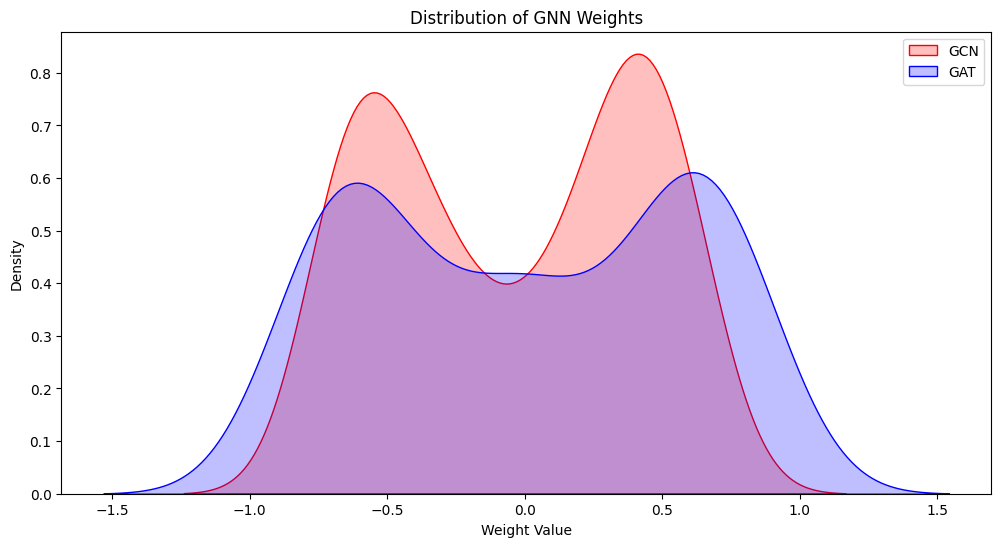

In [51]:
############# Your code here ############
## 1. Extract the weights from the second graph
## convolutional layer (gc2) of the GCN model
Omega_GCN_gc2 = model_GCN.gc2.weight.detach().cpu().numpy()
## 2. Extract the weights from the second graph
## convolutional layer (gc2) of the GAT model
Omega_GAT_gc2 = model_GAT.gc2.weight.detach().cpu().numpy()
## Note: use detach to avoid using the computation graph
## convert the tensor to a numpy array
## use Omega_GCN_gc2 and Omega_GAT_gc2 as variable names
## (~2 lines of code)

#########################################
plot_weight_distributions(Omega_GCN_gc2, Omega_GAT_gc2)

Reflect on the observed distributions of the weights from the models. What conclusions or understandings can be drawn about the behavior and characteristics of each model based on these distributions?






## Discussion of weights distribution

Both weight distributions appear somewhat bimodal (i.e. there are two ranges of particularly common weights). There are very few weights in greater magnitude than the absolute value of 1 which is good (it implies that dropout prevented any model weights getting too large). Weights appear clustered around plus and minus 0.5 for both GAT and GCN, with relatively fewer weights around zero. 

However, there are more GAT weights at the tails suggesting that in GAT there is some strong feature influence/ some specific features identified which are highly influential for predicting the target variable. Furthermore, having fewer weights around zero might be a reflection of the higher model complexity by being able to capture attention.

### Metrics

In [52]:
metrics = {"acc": accuracy, "sensitivity": sensitivity, "specifity": specificity}
results_GCN = test(model_GCN, features, adj,
                   labels, train_mask, val_mask, test_mask, metrics)
results_GAT = test(model_GAT, features, adj,
                   labels, train_mask, val_mask, test_mask, metrics)

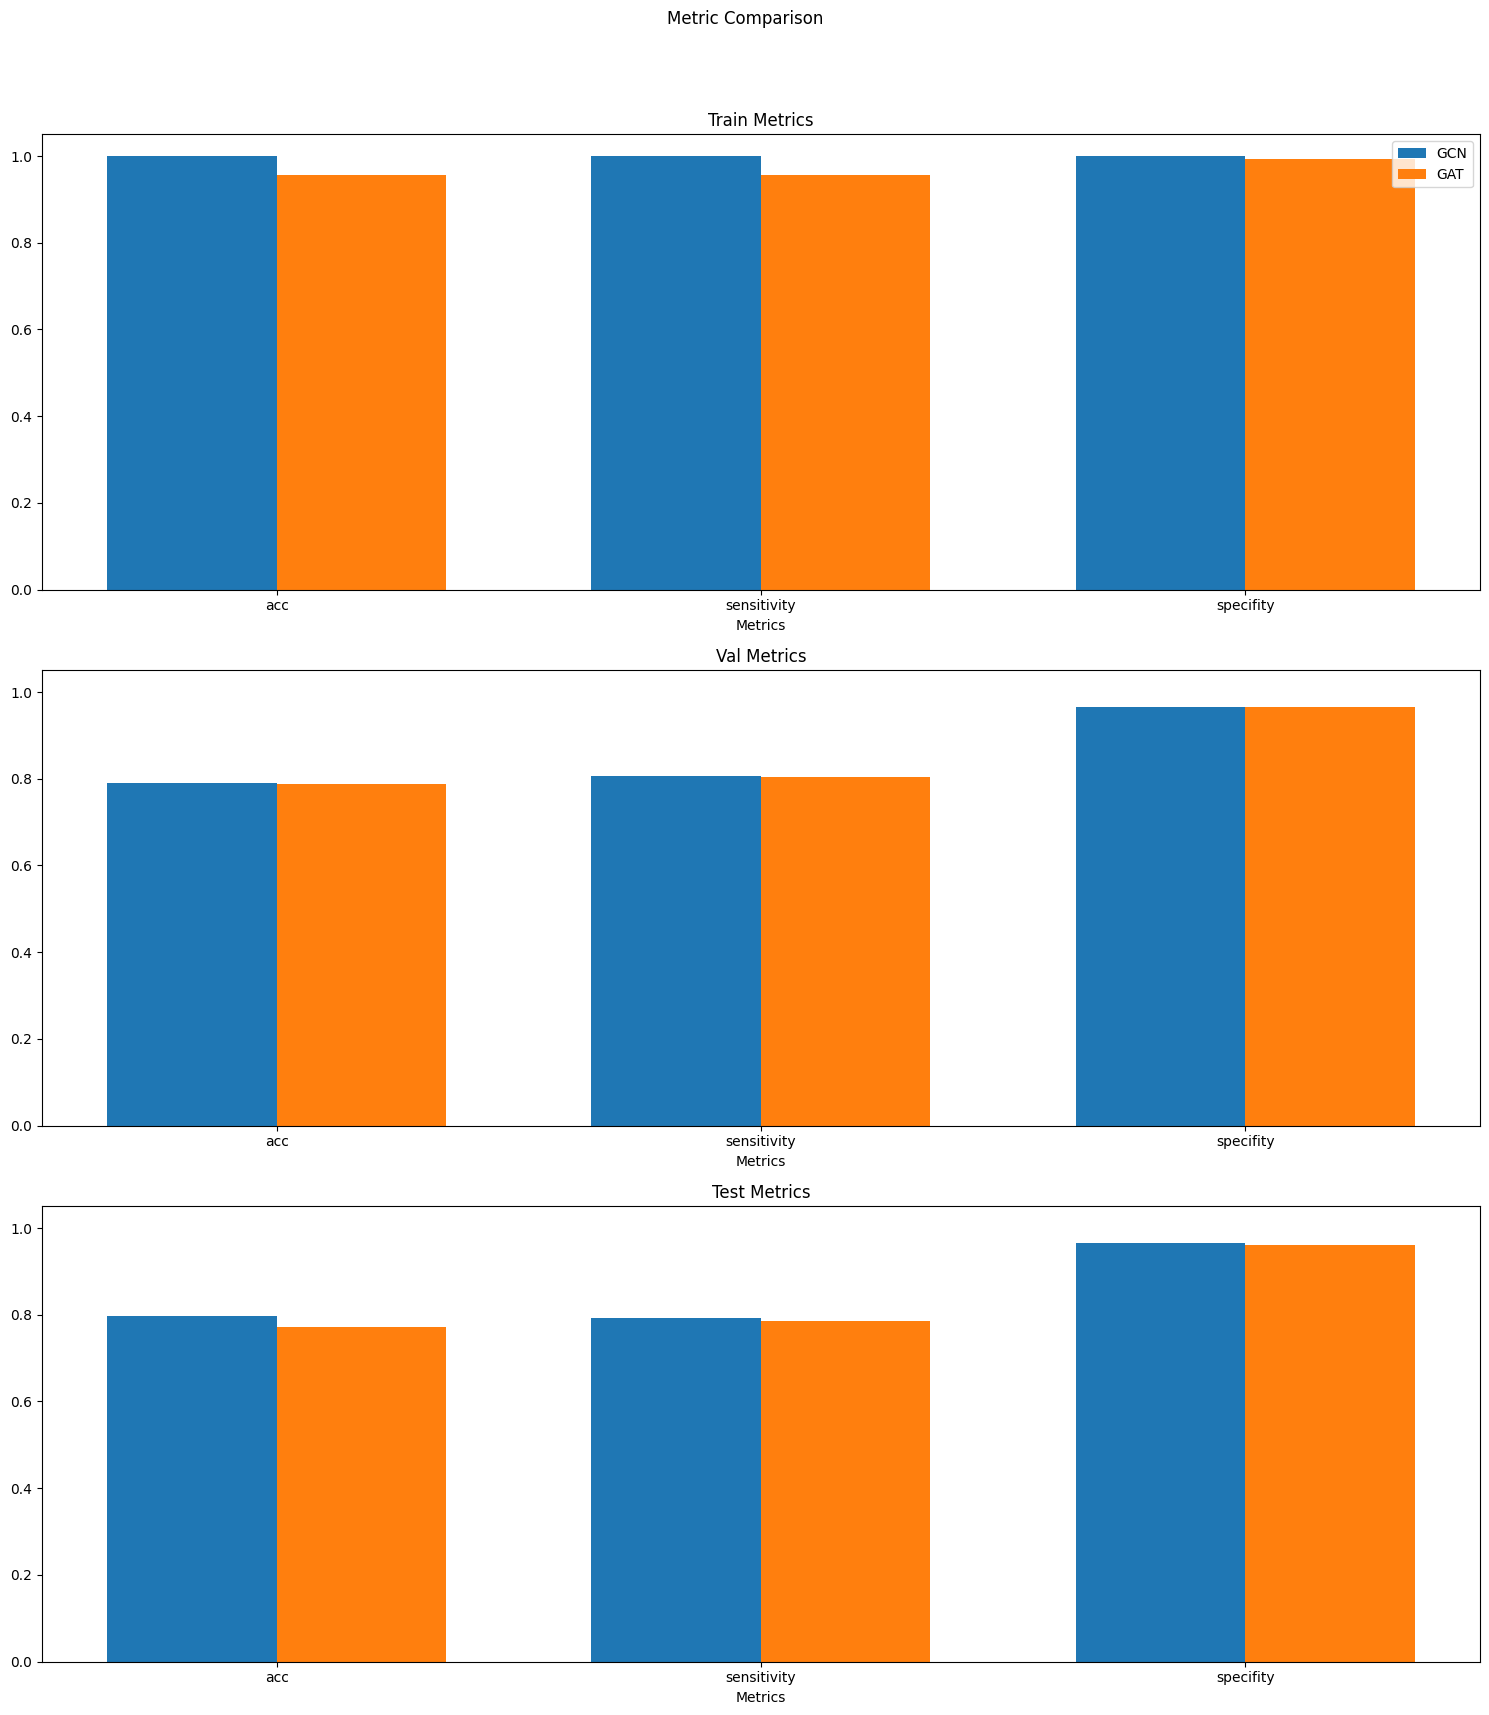

In [53]:
plot_metrics([results_GCN, results_GAT], 'Metric Comparison')

How might you interpret the outcomes of these results?






## Discussion on outcomes

Both models perform largely the same across the three metrics of accuracy, sensitivity and specificity. However, it appears that the GCN does slightly better at training. When I've run this multiple times over different seeds, sometimes that the GCN performs marginally better at test, and sometimes it's the GAT. This would suggest that we should be largely indifferent with respect to accuracy about which model we choose and that the which one is specifically better in the above charts is largely a consequence of randomness.

## Bonus question 1

What changes in the GCN and GAT layers would result in a more effective implementation?

Hint: See how [message passing](https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html) is implemented in PyTorch Geometric.

Furthermore, explore the specific implementations for [GCN](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html) and [GAT](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GATConv.html).

*Note: Bonus questions are ungraded yet provide an opportunity for those who wish to delve deeper into their graph based learning journey.*


######## Your response here (double-click) ########



#########################################

## Bonus question 2

Write the kipf normalization

$H_{k+1} = a[\beta_k\mathbf{1}^T + \Omega_kH_k(D^{-1/2}AD^{-1/2}+I)]$

*Note: Bonus questions are ungraded yet provide an opportunity for those who wish to delve deeper into their graph based learning journey.*


In [ ]:
def kipf_normalization(A):
  ############# Your code here ############

  #########################################
  return A

# 4) Propagation rule integrating edge features/embeddings (15 points)

In [54]:

seed = 42
np.random.seed(seed)  # Setting a fixed seed for numpy random number generator


# we will create a stochastic block model graph with two communities and 20 nodes
G = nx.stochastic_block_model(sizes=[10, 10], p=[[0.8, 0.1], [0.1, 0.8]], seed=seed)

# We will create a node feature
communities = nx.community.louvain_communities(G)
X = np.zeros((len(G), 1))
X[list(communities[0])] = 1

A = nx.adjacency_matrix(G).todense()

# we will use powers of the adjacency matrix as edge features (considering edge embeddings only on edges already existing)
E1 = A
E2 = (A @ A)*A # we zero the embedding on edges which aren't connected
E3 = (A @ A @ A)*A
E4 = (A @ A @ A @ A)*A

E = np.stack((E1, E2, E3, E4), axis = 2)

### 4.1) Graph visualization <b>(5 points)</b>

#### 4.1.1 Use networkx to visualize the structure and the node features of the graph. (2 points)

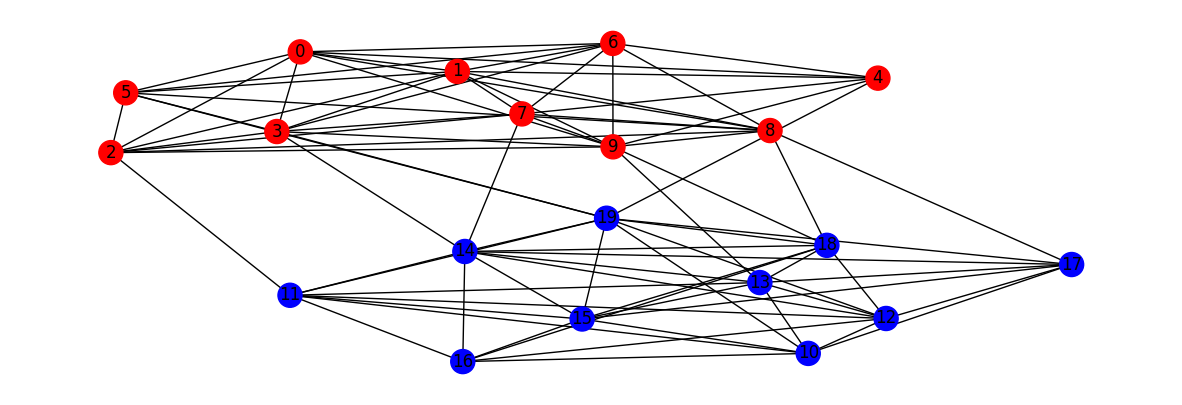

In [55]:
def VisualizeGraphNetworkx(G):
    '''
    input: G
    A networkx graph instance
    '''
    #Complete code here:
    # Let's map the communities to colours
    community_colours = {node: ('r' if X[node] == 1 else 'b') for node in range(len(X))}
    fig, axes = plt.subplots(1, 1, figsize=(15, 5))
    pos = nx.spring_layout(G)  # Using spring layout for visual aesthetics
    nx.draw(G, pos, node_color=[community_colours[node] for node in G.nodes()], with_labels=True)
    ####################

    plt.show()
VisualizeGraphNetworkx(G)

#### 4.1.2 Display the edge features for edges which are connected to node 0 (first node). (3 points)

In [56]:
''' code to display the edge features for all edges connected to node 0. List the output in the format
[node 0, node x, edge_features]
[node 0, node y, edge_features] ...
 Please change = None to your implementation.'''
connected_nodes = np.nonzero(A[0])[0] # These are the nodes which are connected to node 0
edge_features = [] # Initialise to collect the information
# Now iterate over those nodes connected with node 0
for node in connected_nodes:
    features = E[0, node]
    edge_features.append([0, node, features])

print(edge_features)

[[0, 1, array([  1,   7,  50, 390], dtype=int32)], [0, 2, array([  1,   5,  44, 323], dtype=int32)], [0, 3, array([  1,   5,  48, 346], dtype=int32)], [0, 4, array([  1,   3,  37, 243], dtype=int32)], [0, 5, array([  1,   5,  39, 295], dtype=int32)], [0, 6, array([  1,   6,  46, 350], dtype=int32)], [0, 8, array([  1,   5,  47, 334], dtype=int32)], [0, 9, array([  1,   6,  49, 379], dtype=int32)]]


### 4.2 Mathematical Formulation <b>(5 points)</b>

Consider a graph with node embedding $\mathbf{h}_n$ based on its neighboring node embeddings $\{\mathbf{h}_m\}_{m \in ne[n]}$ and the neighboring edge embeddings $\{\mathbf{e}_m\}_{m \in nee[n]}$
$ne[n]$ denotes the neighbors of node $n$ and $nee[n]$ denotes the edges connected to node $n$.
  
Let the update rule without accounting for edge embeddings is the following

$\mathbf{H}_{k+1} = a[ \mathbf{\beta}_k \mathbf{1}^T + \mathbf{\Omega}_k \mathbf{H}_k (\mathbf{A} + \mathbf{I}) ]$

#### 4.2.1 fill in the [...] in the equation below so that we account for edge embeddings (3 points)

$\mathbf{H}_{k+1} = a[ \mathbf{\beta}_k \mathbf{1}^T + \mathbf{\Omega}_k \mathbf{H}_k (\mathbf{A} + \mathbf{I}) + \mathbf{E}_k \mathbf{\Psi_k}]$  (1)

#### 4.2.2 Define any new variables you introduce in the matrix form of (1) and specify their size. (2 points)

Edge embeddings are represented by the matrix $\mathbf{E}_k$, in which each element $(i,j)$ reprensents the average of edge embeddings across the 1, 2, 3, 4 hop edge features. The elements of the edge features are standardised using the mean and standard deviation per edge feature tensor. In addition, I've applied a scaling factor to shrink the aggregated edge embeddings down in order to avoid the weights becoming unstable (this could be a learnable parameter in a ML setting). Finally, it has the same dimensionality as the adjacency matrix, i.e. num_nodes x num_nodes.

$\mathbf{\Psi_k}$ is our matrix of learned parameters to weight the matrix $\mathbf{E}_k$. To ensure that dimensions match, $\mathbf{\Psi_k}$ has dimensions num_nodes x out_features.

### 4.3) Implementation <b>(5 points)</b>

In [57]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
np.random.seed(42)  # Setting a fixed seed for numpy random number generator
torch.manual_seed(42)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def add_self_connections(A):
    """
    Add self-connections to the adjacency matrix.

    This function adds an identity matrix to the adjacency matrix `A`, which
    effectively adds a self-loop to each node in the graph. This is a common
    preprocessing step in graph neural network implementations.

    Parameters:
    A (np.ndarray): The adjacency matrix to modify.

    Returns:
    np.ndarray: The adjacency matrix with self-connections added.
    """
    I = np.eye(A.shape[0])
    return A + I


def normalize_adjacency(A_hat):
    """
    Normalize the adjacency matrix.

    This function applies symmetric normalization to the adjacency matrix
    `A_hat`. The normalization is done using the inverse square root of the
    degree matrix. This step is important for many graph-based learning
    algorithms to ensure that the scale of the feature representations is not
    skewed by node degree.

    Parameters:
    A_hat (np.ndarray): The adjacency matrix with self-connections.

    Returns:
    np.ndarray: The normalized adjacency matrix.
    """
    D_hat_inv_sqrt = np.diag(1.0 / np.sqrt(np.sum(A_hat, axis=0)))
    return D_hat_inv_sqrt.dot(A_hat).dot(D_hat_inv_sqrt)



# GCN update steps
A_hat = add_self_connections(A) # A is from question 1.2

# define input features
H_k = X

# Define the dimensions of the weight matrix
input_features = H_k.shape[1]  # Number of input features (columns of H_k)
output_features = 2  # Number of output features (can be chosen based on your model's design)

# Initialize the weight matrix Omega_k with random values
Omega_k = np.random.rand(input_features, output_features)

#### 4.1 Implement equation (1) and print out an update using this equation

In [117]:
''' Please implement your update which includes edge embeddings below (change = None)
You should use A, X and E defined at the beginning of 4)

'''
# First, get the normalisations across the walks. This ensures the mean of walks is to some extent scale-invariant.
def normalize_edge_embeddings(E):
    # Compute mean and std across all edge embeddings
    mean = np.mean(E, axis=(0, 1))
    std = np.std(E, axis=(0, 1))
    
    # Normalize
    E_normalized = (E - mean) / std
    return torch.tensor(E_normalized, dtype=torch.float32)

# Normalize edge embeddings
for i in range(E.shape[2]):
    E[:, :, i] = normalize_edge_embeddings(E[:, :, i])

# Then take the average, so each (i,j) is the average connectivity across all walks
E_avg = np.mean(E, axis=2)

# Apply a scaling factor to edge embeddings to control their magnitude
scaling_factor = 0.1
E_scaled = E_avg * scaling_factor

# Initialize the matrix Psi_k with random values for edge embedding parameters
Psi_k = np.random.rand(E.shape[0], output_features)

# Create a bias initialisation if you want to train
bias = np.random.rand(E.shape[0], output_features)

# Get the update with edge embeddings
H_k_edge_embeddings = A_hat @ H_k @ Omega_k + E_scaled @ Psi_k + bias

#print("\nWith edge-embeddings:\n", H_k_edge_embeddings)
# Uncomment if you want to compare without edge embeddings
#H_k_without_edge_embeddings = A_hat @ H_k @ Omega_k + bias
#print("\nWithout edge-embeddings:\n", H_k_without_edge_embeddings)

# 5) Bonus (5 points)

#### Graph Fusion

In [113]:


# here we have two datasets of the same digits. One using pixels and the other in the Fourier Domain.

# load digits in fourier domain
df1 = pd.read_csv('sample_data/fourier.csv', header=None)
X1 = df1.to_numpy()
print(len(X1))

# load digits in pixel domain
df2 = pd.read_csv('sample_data/pixel.csv', header=None)
X2 = df2.to_numpy()
print(len(X2))


# generate distances between all pairs of points to create distance matrix
A1 = euclidean_distances(X1,X1)
A2 = euclidean_distances(X2,X2)

600
600


Here we have two graphs $G =(A1,X1)$ and $G' = (A2,X2)$ representating the same dataset in different domains.

#### 5.1) Use the SNF graph cross-diffusion rule (see equations (4) and (5) in the SNF paper) to define a function $G_f = fuse(G,G')$ that fuses the node and edge features of these two graphs. Formalize the solution mathematically in the matrix form (2 points)

$\mathbf{P}^{G}_{f}$ = $\frac{\mathbf{P}^{G}_{t} + \mathbf{P}^{G'}_{t}}{2}$ after $t$ steps.

where cross-diffusion occurs by the following iterative procedure:

$\mathbf{P}^{(G)}_{t+1} = \textbf{S}^{(G)} \times \textbf{P}^{(G')}_{t} \times (\textbf{S}^{(G)})^{T}$

$\mathbf{P}^{(G')}_{t+1} = \textbf{S}^{(G')} \times \textbf{P}^{(G)}_{t} \times (\textbf{S}^{(G')})^{T}$

#### 5.2) Cross-diffuse graphs G and G' above using your new formula. (3 points)

In [120]:
def construct_weight_matrix(array):
    mu = 0.5 # Takes range between [0.3, 0.8]
    row_means = array.mean(axis=1)
    col_means = array.mean(axis=0)
    eta_i_j = (array + row_means[:, np.newaxis] + col_means)/3
    eucl_sq = -np.square(array)
    W = np.exp(eucl_sq/(mu*eta_i_j))
    return W

def construct_P_matrix(array):
    W = construct_weight_matrix(array)
    D = np.copy(W).sum(axis = 1)
    D_inv = np.diag(1.0 / D)
    P = D_inv @ W
    np.fill_diagonal(P, np.diag(P)*0.5) # for numerical stability
    return P

def construct_S_matrix(array, K):
    W = construct_weight_matrix(array)
    
    # Get local neighbourhood
    kth_pos = array.shape[1] - K
    topK_values = np.partition(array, kth_pos, axis = 1)[:, kth_pos:]
    mask = np.zeros_like(array, dtype=bool)
    for i in range(K):
        mask |= array == np.expand_dims(topK_values[:, i], axis=1)
    S = array.copy()
    S[~mask] = 0 # set all other values to zero
    return S

# Use KNN=3
P = construct_P_matrix(A1)
S = construct_S_matrix(A1, 3)
P_prime = construct_P_matrix(A2)
S_prime = construct_S_matrix(A2, 3)

# Iterate the two parallel interchanging diffusion processes
i = 0
while i < 1:
    P_t1 = S @ P_prime @ S.transpose()
    P_prime_t1 = S_prime @ P @ S_prime.transpose()
    P = P_t1
    P_prime = P_prime_t1
    i += 1

P_fuse = (P + P_prime)/2


#### References:
1. SNF paper: Wang, Bo, et al. "Similarity network fusion for aggregating data types on a genomic scale." Nature methods 11.3 (2014): 333-337.
2. Feel free to check  <A Href="https://www.youtube.com/watch?v=Oqrjkm6TIy8&list=PLug43ldmRSo3MV-Jgjr30E5SpwNKkjTvJ&index=32">video</A> from minute 21 to 30 (9 minutes to cover).